In [1]:
import torch
import pickle
from tqdm import tqdm
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
from matplotlib import rc
matplotlib.rcParams['figure.dpi'] = 150
f_path = "/System/Library/Fonts/Helvetica.ttc"
font_name = fm.FontProperties(fname=f_path).get_name()
rc('font', family=font_name, size=13)

import matplotlib.pyplot as plt
from sentence_transformers import models, SentenceTransformer
from collections import defaultdict
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
from scipy.stats import binned_statistic

In [2]:
model_types = ['model_bert_ft', 'model_roberta-base_ft', 'model_bert', 'model_roberta-base']#, 'model_sbert_ft', 'model_sbert'
model_labels = ['BERT (Fine-tuned)', 'S-BERT (Fine-tuned)', 'BERT', 'S-BERT'] #, 'Finetuned SBERT roberta', 'SBERT roberta'

In [3]:
data_idx = 0

In [4]:
#load dictionary {beliefs: embedding vector}  

model2beleifemb = {}
for model_type in model_types:
    with open('../dataset/BeliefEmbeddingResults/BeliefEmbeddings_data(0)_model(%s).p'%(model_type), 'rb') as f:
        model2beleifemb[model_type] = pickle.load(f)


## load belief vectors

In [5]:
belief_keys = list(model2beleifemb['model_roberta-base_ft'].keys())
belief_vectors = list(model2beleifemb['model_roberta-base_ft'].values())

idx2belief = {}
belief2idx = {}

for i in range(len(belief_keys)):
    idx2belief[i] = belief_keys[i]
    belief2idx[belief_keys[i]] = i

## PCA of beliefs vectors

In [6]:
from sklearn.manifold import TSNE                   # final reduction
from sklearn.decomposition import PCA                   # final reduction

pca = PCA(random_state=42)
pca.fit(belief_vectors)
pca_vectors = pca.transform(belief_vectors)
pca_x_vals = np.array([v[0] for v in pca_vectors])
pca_y_vals = np.array([v[1] for v in pca_vectors])

dat_pc = pd.DataFrame({'x':pca_x_vals, 'y':pca_y_vals})

### Entire belief space

<Figure size 1500x1200 with 0 Axes>

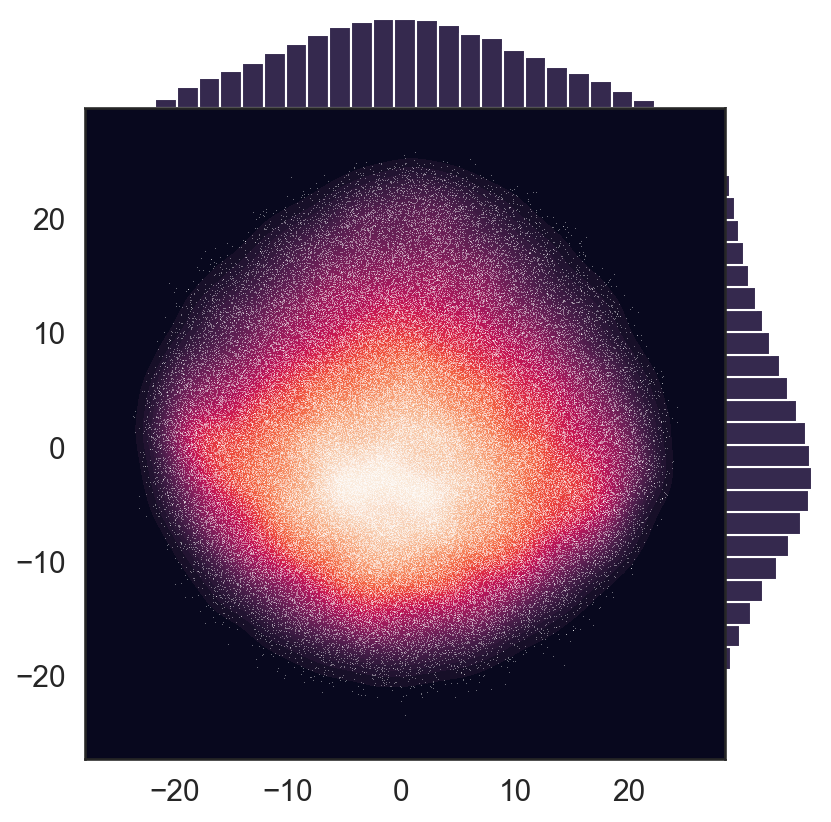

In [627]:
rc = {'figure.figsize':(10,8)}
sns.set_theme(style="white", font_scale=1.3, rc=rc)


plt.figure()
g = sns.JointGrid(data=dat_pc, x="x", y="y", space=0.0, ratio=7)

g.ax_joint.set_facecolor("black")

g.plot_joint(sns.kdeplot,
             fill=True, 
             thresh=0,
             cmap="rocket",
             levels=100)

sns.scatterplot(x=pca_x_vals, y=pca_y_vals, fc="w", s=0.1,  ax=g.ax_joint)

g.plot_marginals(sns.histplot, color="#35294E", alpha=1, bins=25)

g.set_axis_labels(xlabel=None, )

plt.savefig('../fig/BeliefSpaceExamples/belief_space_visualization_smooth.png', transparent=True, bbox_inches='tight')
plt.show()

## Beliefs including specific keywords

In [7]:
def get_related_beliefs(keywords, pc_x=0, pc_y=1): 
    #pc_x, pc_y = pc index
    related_beliefs = set()
    related_beliefs_vectors = []
    related_beliefs_pcvec = []

    for e in belief_keys:
        for k in keywords:
            if k.lower() in e.lower(): #convert to lower case 
                related_beliefs.add(e)
    
    related_beliefs = list(related_beliefs)
    for b in related_beliefs:
        b_idx = belief2idx[b]
        related_beliefs_vectors.append(belief_vectors[b_idx])
        related_beliefs_pcvec.append(pca_vectors[b_idx])

    related_beliefs_vectors = np.array(related_beliefs_vectors)            
    related_beliefs_pcvec   = np.array(related_beliefs_pcvec)

    x = related_beliefs_pcvec[:,pc_x]
    y = related_beliefs_pcvec[:,pc_y]
    
    dat = pd.DataFrame({'x':x, 'y':y, 'belief':related_beliefs})
    
    print("N samples:", len(x))
    return x, y, dat

In [8]:
def draw_keyword_kde(keywords, pc_x=0, pc_y=1, palette='rocket', labeloff=0):
    
    color = palette
            
    x, y, dat = get_related_beliefs(keywords, pc_x, pc_y)
    sns.set_theme(style="white", font_scale=1.3)
    g = sns.JointGrid(data=dat, x="x", y="y", space=0.0, ratio=7)
    
    
    sns.kdeplot(data=dat, x='x', y='y', fill=True, thresh=0, cmap=color, levels=100, ax=g.ax_joint)
    g.ax_joint.set_facecolor("black")
    g.plot_marginals(sns.histplot, color="#35294E", alpha=1, bins=25)
    g.set_axis_labels(xlabel=None)
    
    ax=g.ax_joint
    ax.set_xticks([-20, 0, 20])
    
    if labeloff==0:
        if len(keywords) > 2:
            ax.text(.02, .97,  s=", ".join(keywords), ha='left', va='top', color='w', fontsize=22, transform=ax.transAxes)
        else:
            ax.text(.02, .97,  s=", ".join(keywords), ha='left', va='top', color='w', fontsize=23, transform=ax.transAxes)
        
    return g

N samples: 5324


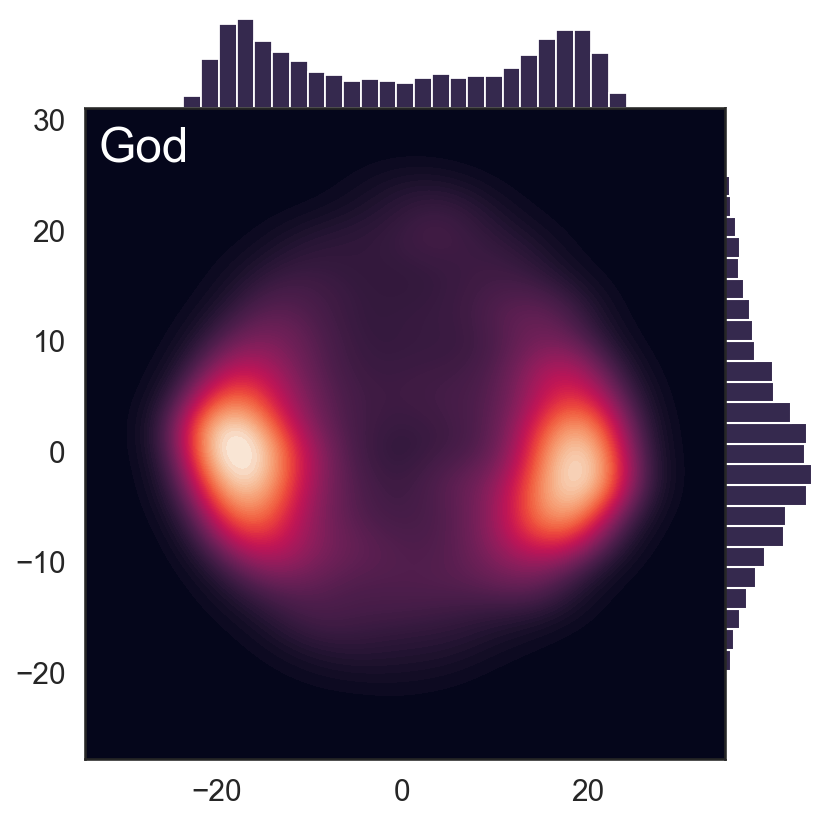

In [630]:
keywords = ['God']
draw_keyword_kde(keywords, labeloff=0)
plt.savefig('../fig/BeliefSpaceExamples/belief_kdeplot_keyword_(%s)'%(keywords[0]), transparent=0, bbox_inches='tight')

### PC1 - PC2

N samples: 908
N samples: 3860
N samples: 1302
N samples: 1392
N samples: 464
N samples: 380
N samples: 242
N samples: 710


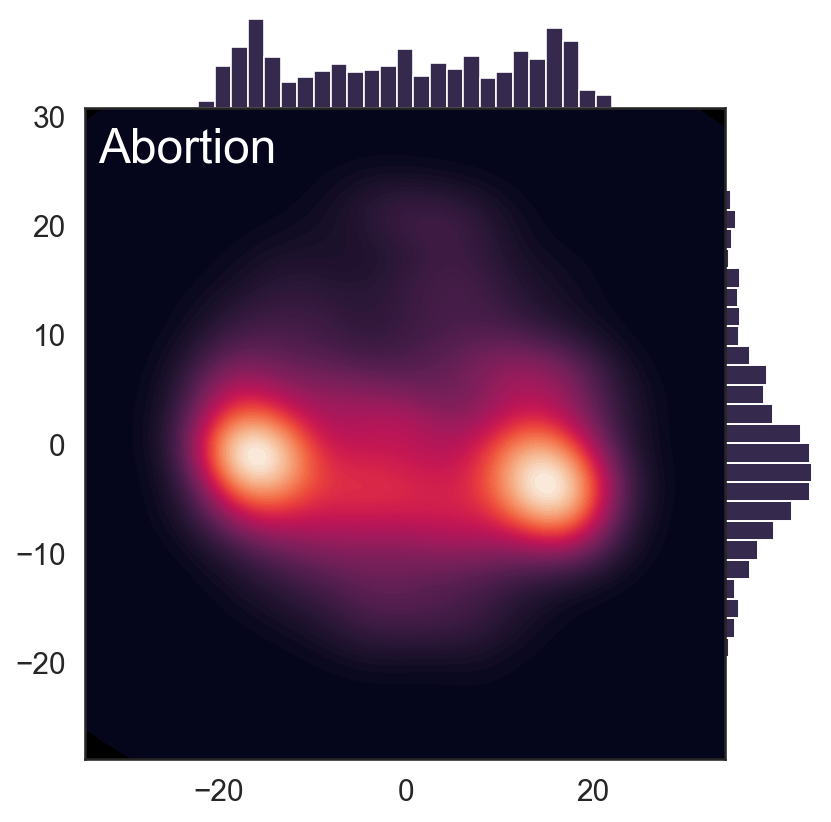

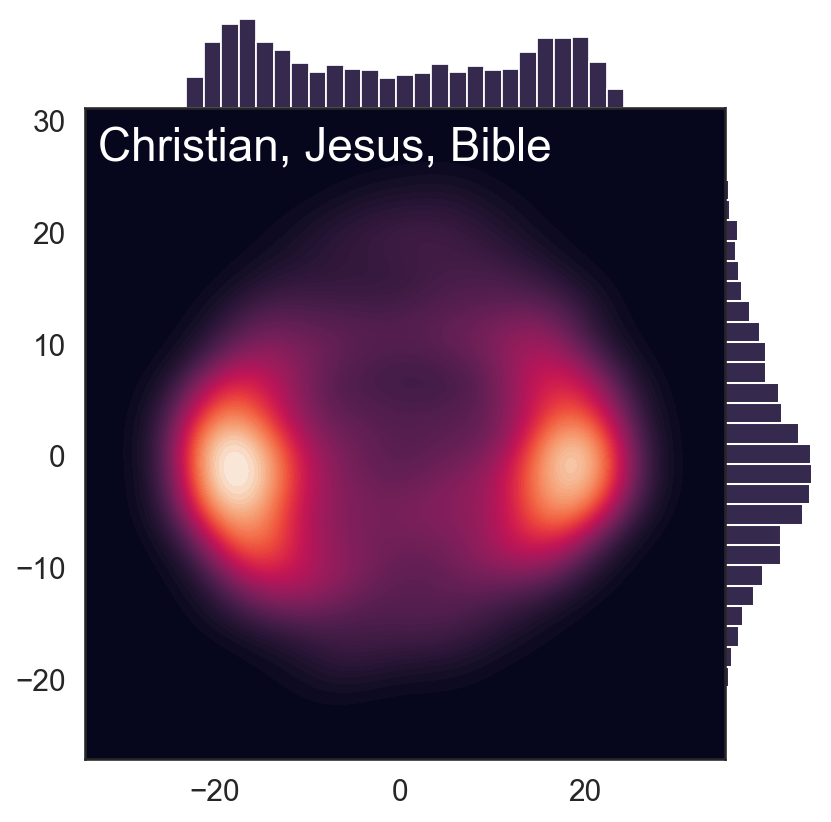

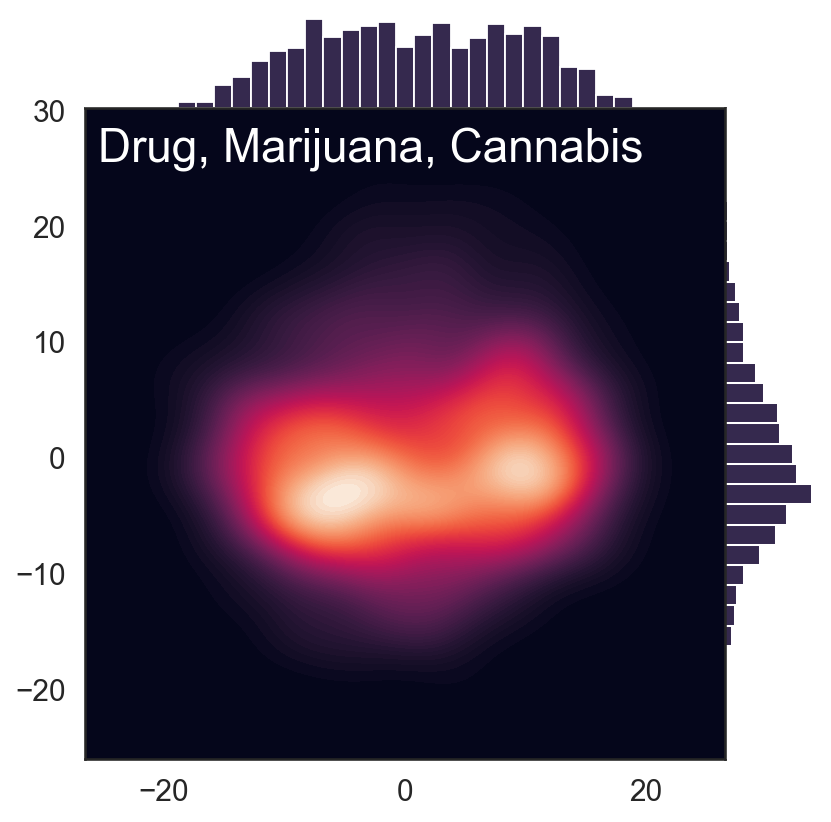

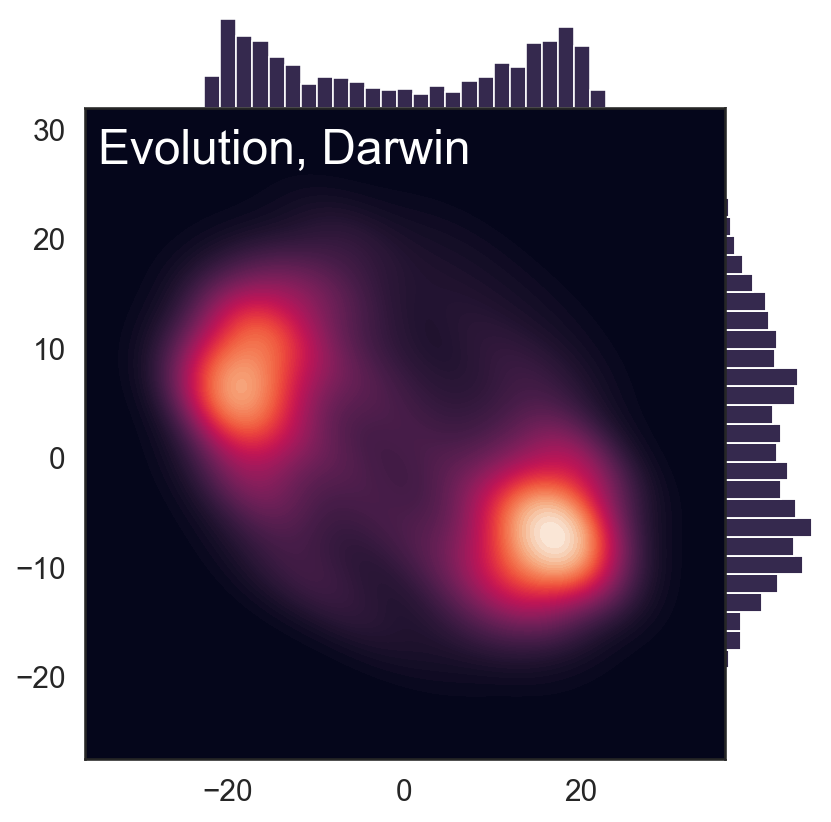

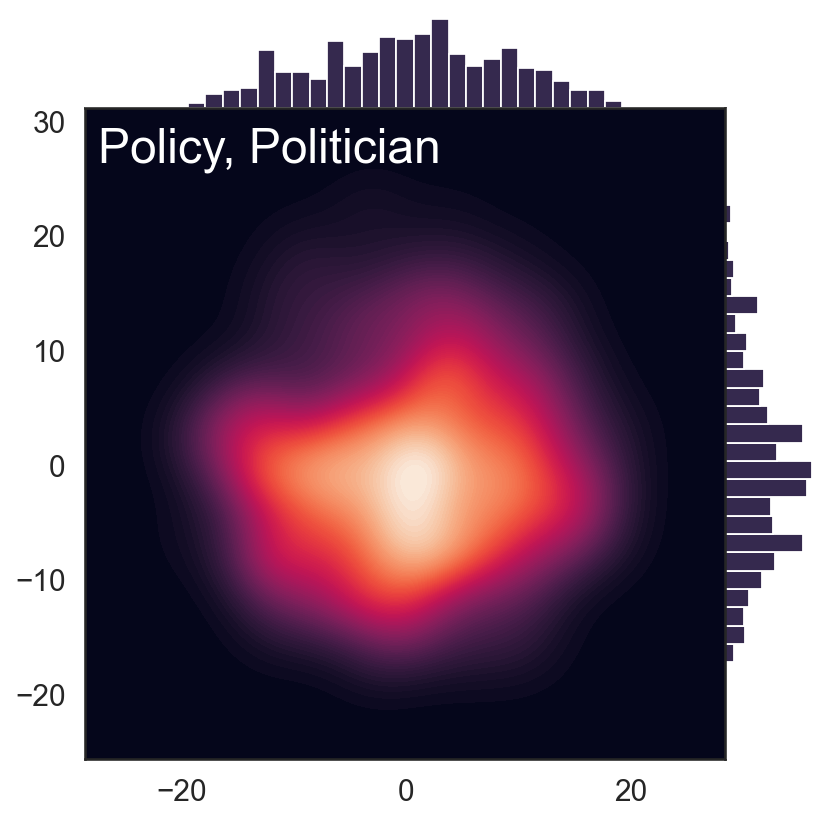

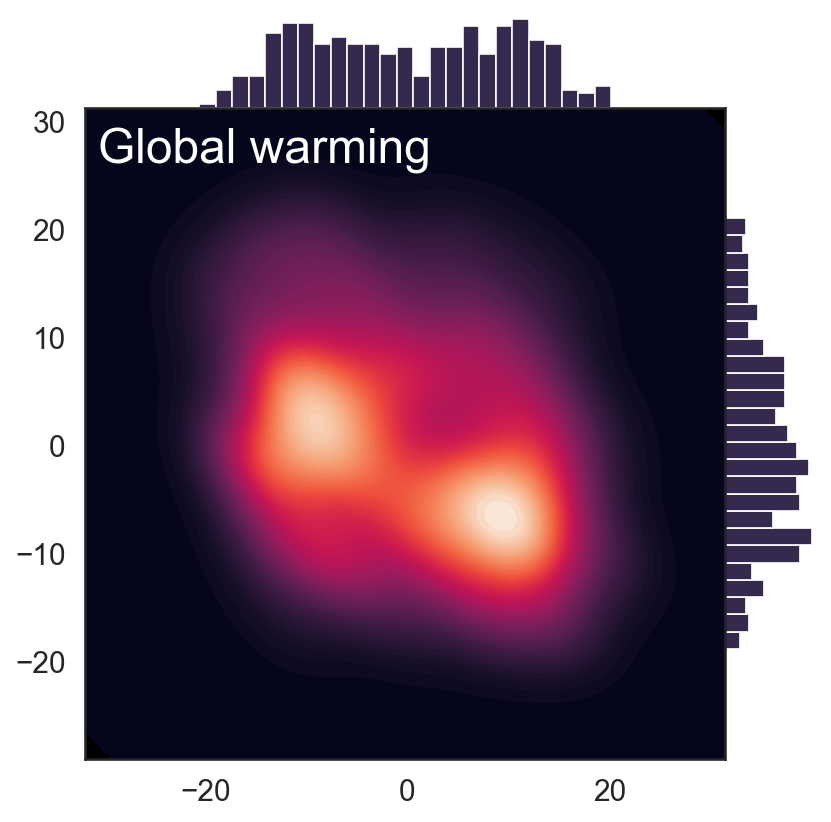

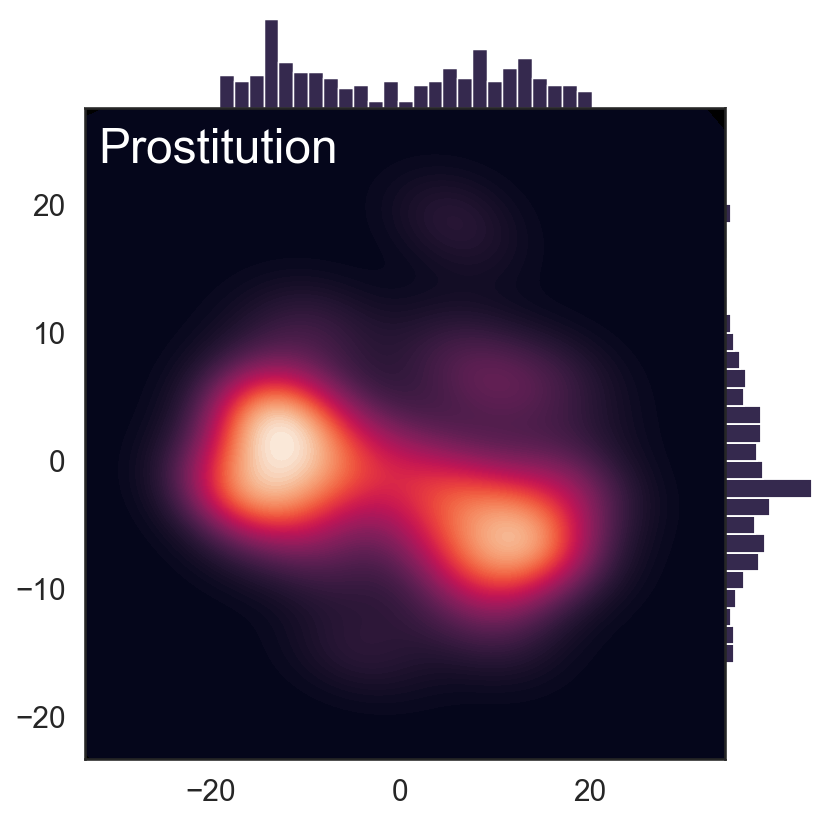

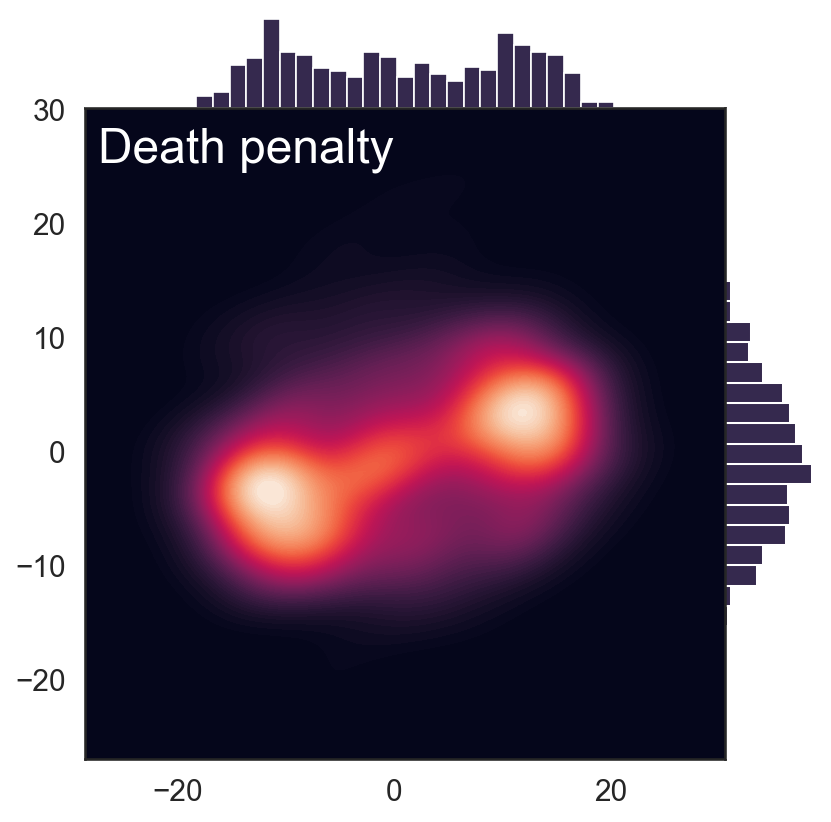

In [20]:
#Data
keywords = ['Abortion']
draw_keyword_kde(keywords)
plt.savefig('../fig/BeliefSpaceExamples/belief_kdeplot_keyword_(%s)'%(keywords[0]), transparent=False, bbox_inches='tight')

keywords = ['Christian', 'Jesus', 'Bible']
draw_keyword_kde(keywords)
plt.savefig('../fig/BeliefSpaceExamples/belief_kdeplot_keyword_(%s)'%(keywords[0]), transparent=False, bbox_inches='tight')

keywords = ['Drug', 'Marijuana', 'Cannabis']
draw_keyword_kde(keywords)
plt.savefig('../fig/BeliefSpaceExamples/belief_kdeplot_keyword_(%s)'%(keywords[0]), transparent=False, bbox_inches='tight')

keywords = ['Evolution','Darwin']
draw_keyword_kde(keywords)
plt.savefig('../fig/BeliefSpaceExamples/belief_kdeplot_keyword_(%s)'%(keywords[0]), transparent=False, bbox_inches='tight')

keywords = ['Policy', 'Politician']
draw_keyword_kde(keywords)
plt.savefig('../fig/BeliefSpaceExamples/belief_kdeplot_keyword_(%s)'%(keywords[0]), transparent=False, bbox_inches='tight')

keywords = ['Global warming']
draw_keyword_kde(keywords)
plt.savefig('../fig/BeliefSpaceExamples/belief_kdeplot_keyword_(%s)'%(keywords[0]), transparent=False, bbox_inches='tight')

keywords = ['Prostitution']
draw_keyword_kde(keywords)
plt.savefig('../fig/BeliefSpaceExamples/belief_kdeplot_keyword_(%s)'%(keywords[0]), transparent=False, bbox_inches='tight')

keywords = ['Death penalty']
draw_keyword_kde(keywords)
plt.savefig('../fig/BeliefSpaceExamples/belief_kdeplot_keyword_(%s)'%(keywords[0]), transparent=False, bbox_inches='tight')

### PC2 - PC3

N samples: 342
N samples: 138


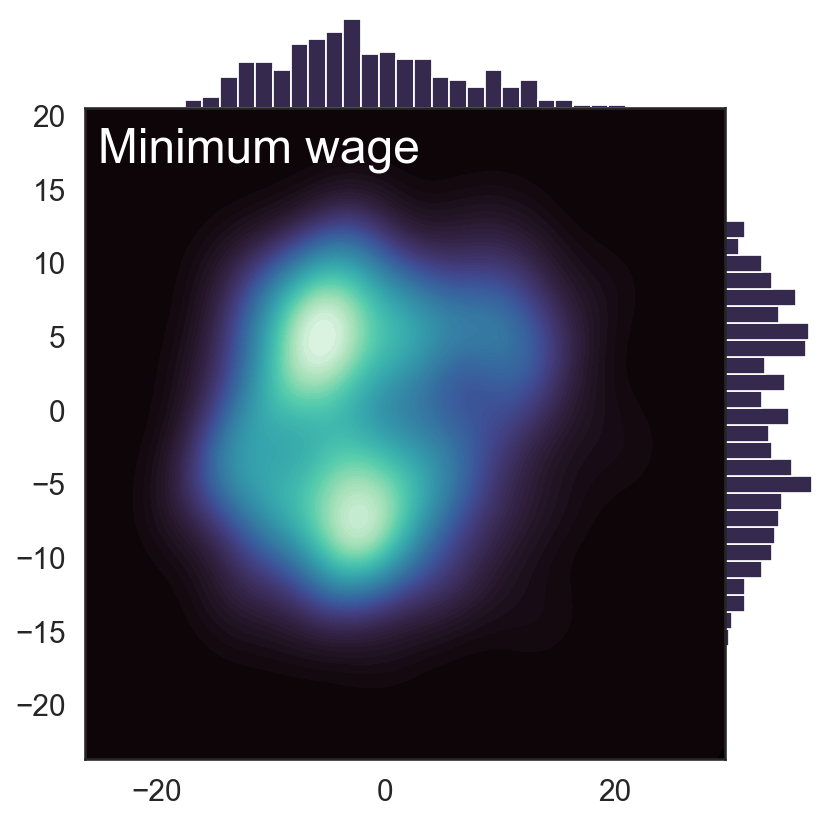

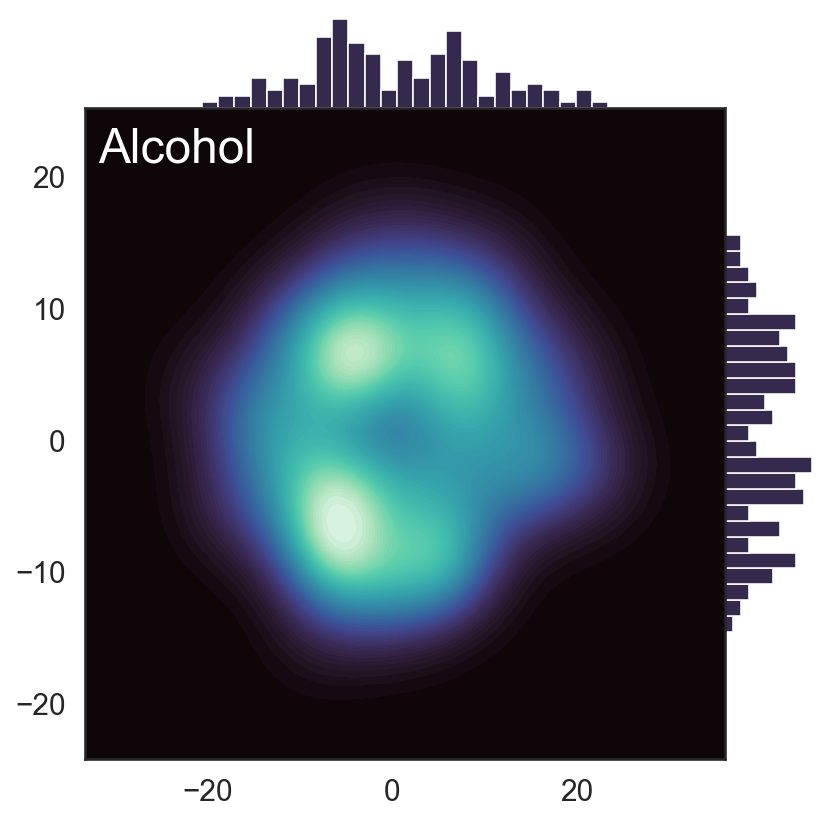

In [18]:
keywords = ['Minimum wage']
draw_keyword_kde(keywords, 1, 2, palette='mako')
plt.savefig('../fig/BeliefSpaceExamples/belief_kdeplot_keyword_(%s)'%(keywords[0]), transparent=False, bbox_inches='tight')

keywords = ['Alcohol']
draw_keyword_kde(keywords, 1, 2, palette='mako')
plt.savefig('../fig/BeliefSpaceExamples/belief_kdeplot_keyword_(%s)'%(keywords[0]), transparent=False, bbox_inches='tight')

### Higher dimension

N samples: 324
N samples: 158
N samples: 140


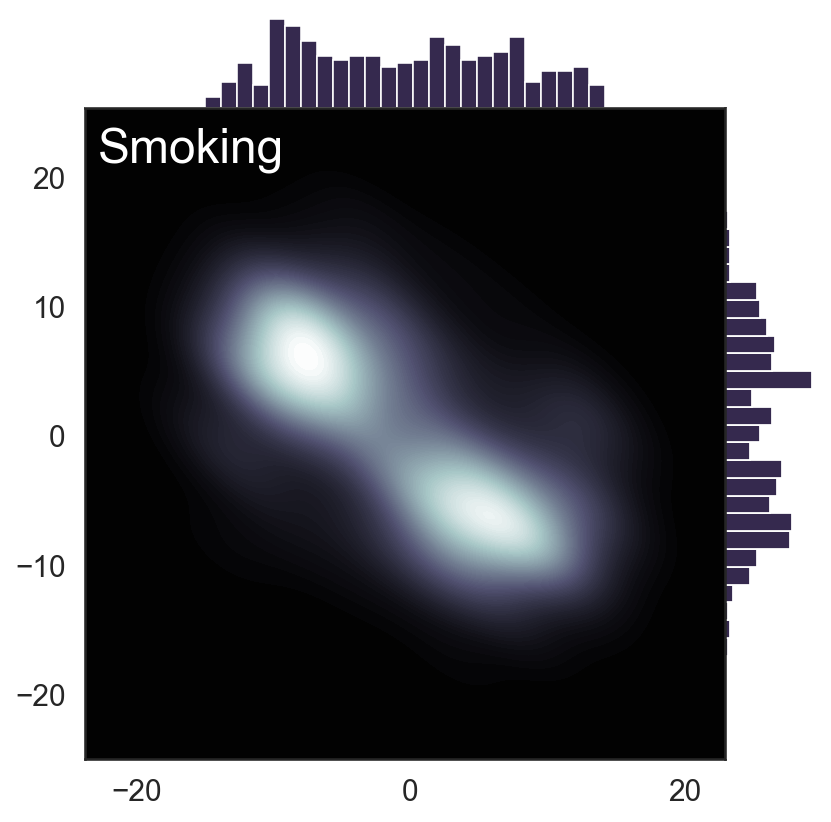

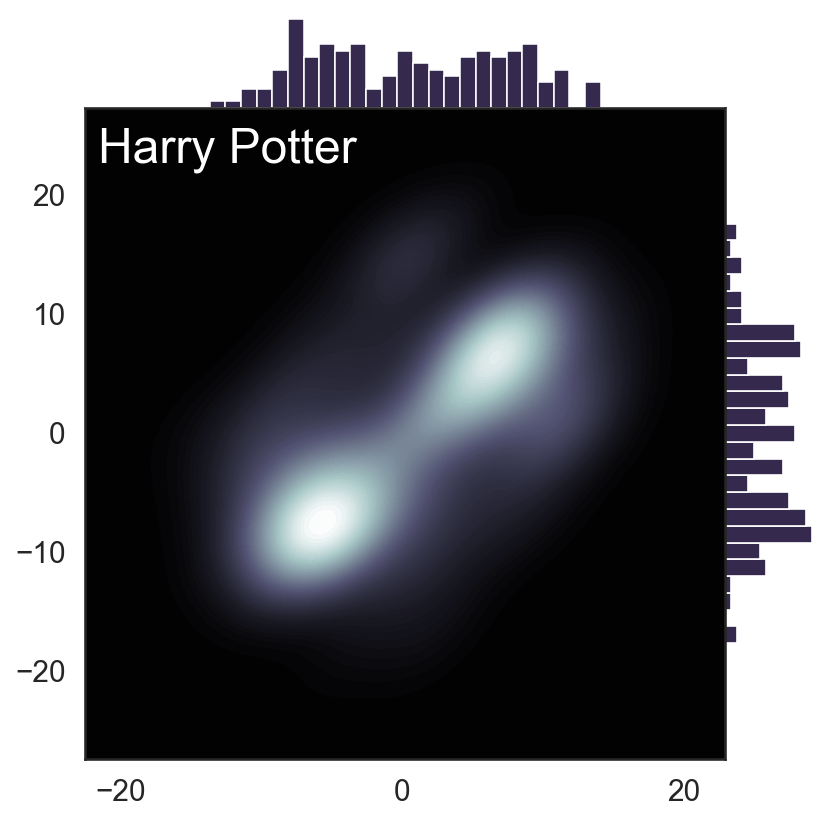

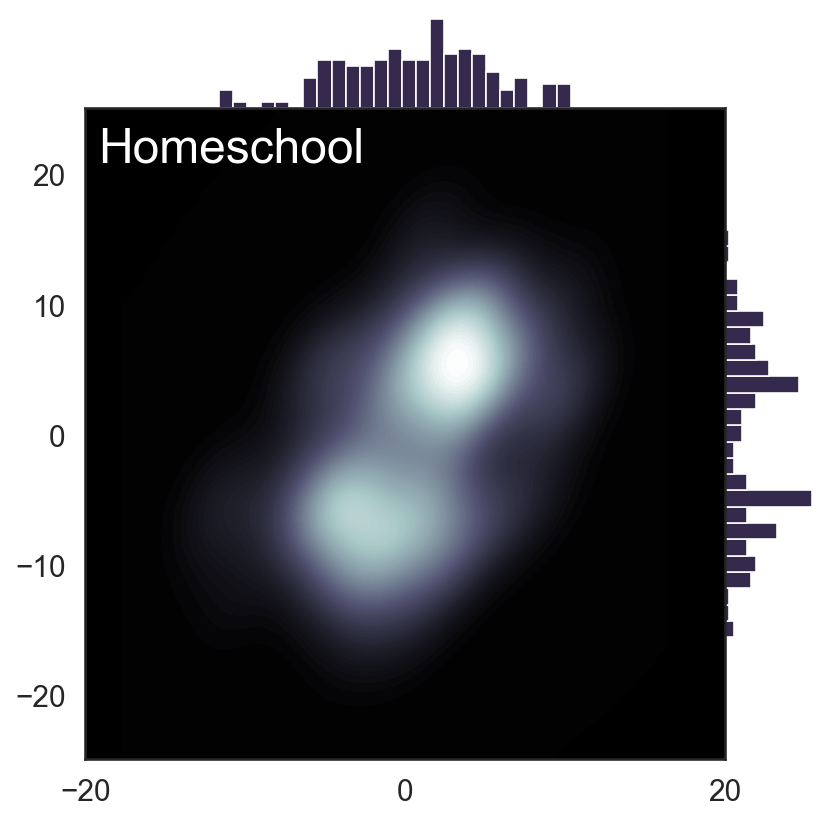

In [34]:
keywords = ['Smoking']
draw_keyword_kde(keywords, 3, 4, palette='bone')
plt.savefig('../fig/BeliefSpaceExamples/belief_kdeplot_keyword_(%s)'%(keywords[0]), transparent=False, bbox_inches='tight')

keywords = ['Harry Potter']
draw_keyword_kde(keywords, 2, 3, palette='bone')
plt.savefig('../fig/BeliefSpaceExamples/belief_kdeplot_keyword_(%s)'%(keywords[0]), transparent=False, bbox_inches='tight')

keywords = ['Homeschool']
draw_keyword_kde(keywords, 2, 3, palette='bone')
plt.savefig('../fig/BeliefSpaceExamples/belief_kdeplot_keyword_(%s)'%(keywords[0]), transparent=False, bbox_inches='tight')

N samples: 698
N samples: 988
N samples: 1066


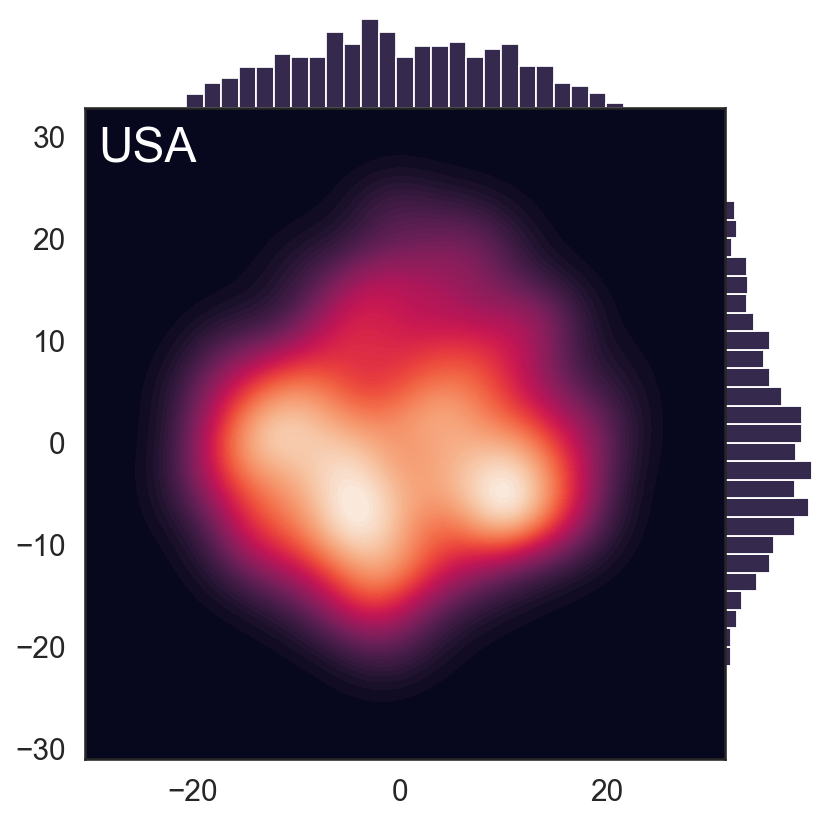

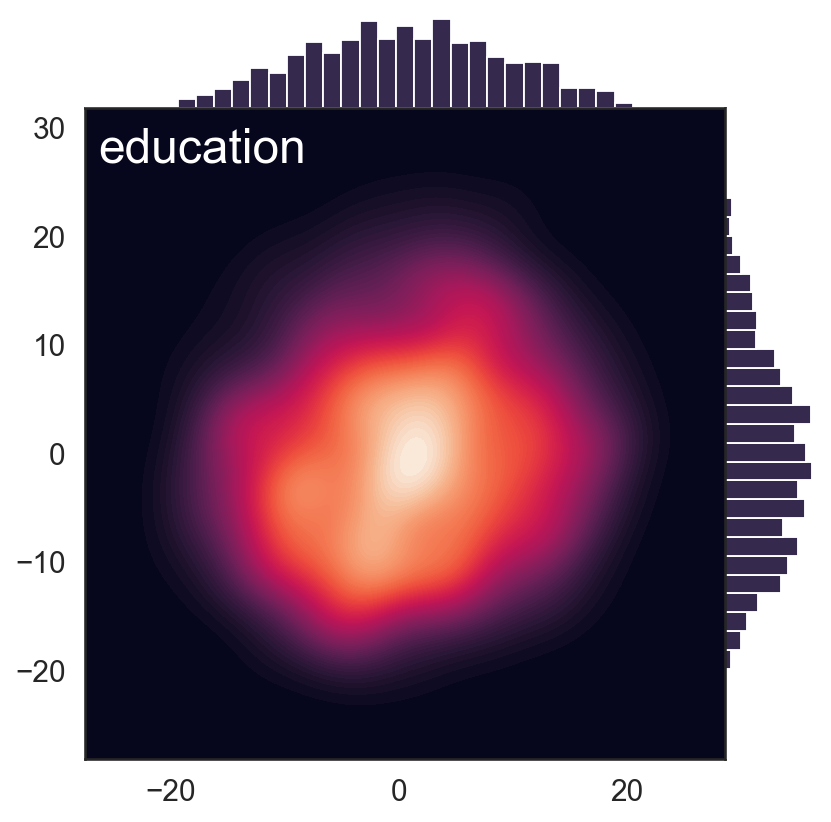

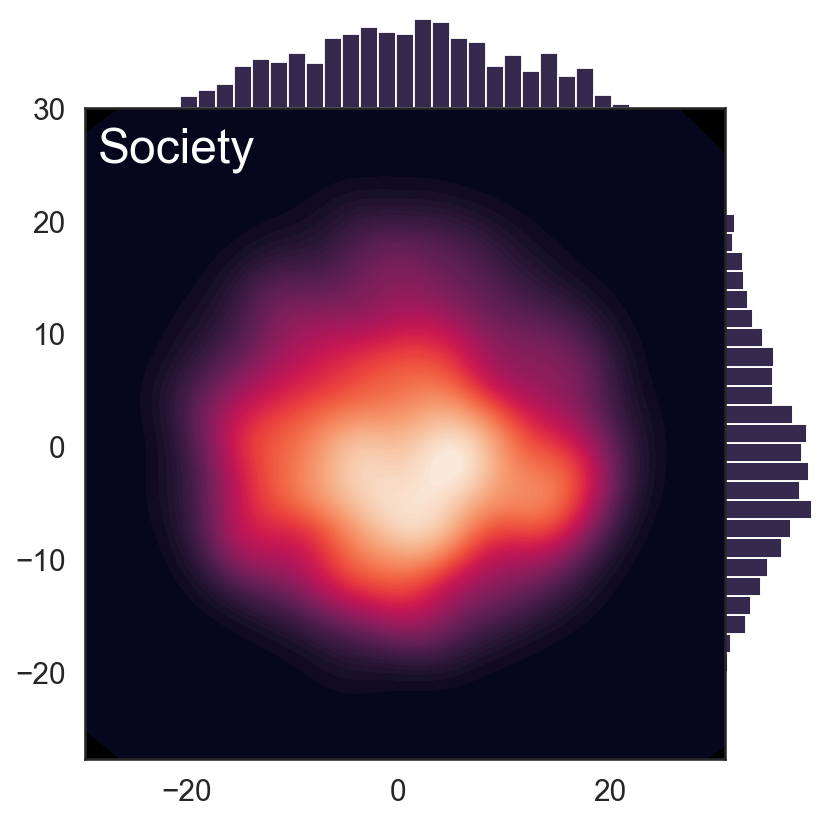

In [12]:
keywords = ['USA']
draw_keyword_kde(keywords, pc_x=0, pc_y=1, labeloff=0)

keywords = ['education']
draw_keyword_kde(keywords, pc_x=0, pc_y=1, labeloff=0)

keywords = ['Society']
draw_keyword_kde(keywords, pc_x=0, pc_y=1, labeloff=0)


## Finding Example beliefs

N samples: 5324


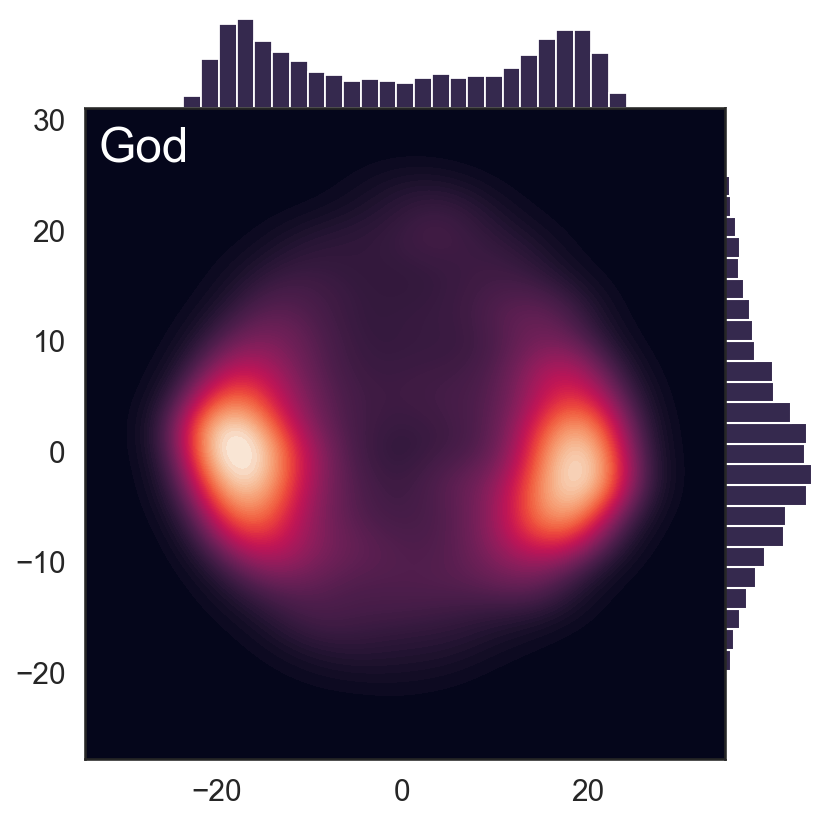

In [39]:
keywords = ['God']
draw_keyword_kde(keywords, 0, 1)

In [60]:
## frequent beliefs..

In [742]:
df_train = pd.read_pickle('../dataset/04_K-fold_dataset/df_train_idx0.p')

In [29]:
belief2cnt = df_train['belief_statement'].value_counts().to_dict()

In [30]:
def get_popular_beliefs(keywords, n=20, pc_x=0, pc_y=1):
    #keywords = ['God']
    x, y, dat = get_related_beliefs(keywords, pc_x, pc_y)
    dat['count'] = dat['belief'].map(belief2cnt)
    dat = dat.sort_values(by='count', ascending=0)
    
    for i in range(n):
        print(i, dat['belief'].iloc[i], "(N:%d)"%(dat['count'].iloc[i]), "(%.1f, %.1f)"%(dat['x'].iloc[i], dat['y'].iloc[i]) )
        
    return dat

### keyword: God

In [76]:
dat = get_popular_beliefs(['God'], n=30)

N samples: 5324
0 I agree with the following: God exists (N:120) (-15.9, 1.3)
1 I disagree with the following: God exists (N:112) (16.5, -6.1)
2 I agree with the following: God Exists (N:111) (-15.9, 1.3)
3 I disagree with the following: God Exists (N:107) (16.5, -6.1)
4 I disagree with the following: God is real (N:73) (14.9, -4.0)
5 I agree with the following: God is real (N:62) (-18.3, -4.5)
6 I disagree with the following: God exists. (N:51) (16.0, -3.6)
7 I agree with the following: God exists. (N:50) (-17.6, -1.5)
8 I disagree with the following: The Existence of God (N:46) (21.7, -1.9)
9 I disagree with the following: God does not exist. (N:42) (-14.7, -5.0)
10 I agree with the following: The Existence of God (N:36) (-19.0, 1.3)
11 I disagree with the following: God does not exist (N:36) (-16.9, -4.0)
12 I agree with the following: The paradox of the stone successfully disproves the Christian God. (N:34) (13.3, -4.1)
13 I agree with the following: God does not exist (N:33) (20.1

In [87]:
dat.head()

x         y                                      belief  count
1366 -15.874414  1.299423      I agree with the following: God exists    120
731   16.450128 -6.060865   I disagree with the following: God exists    112
2067 -15.874414  1.299423      I agree with the following: God Exists    111
4461  16.450128 -6.060865   I disagree with the following: God Exists    107
4552  14.850169 -3.952183  I disagree with the following: God is real     73

In [90]:
#left Pro-God, right Con-God 
god_left_indices = [0, 5, 9, 10, 25]
god_right_indices = [1, 4, 8, 12, 23]

In [91]:
for i in range(5):
    print("(%.1f, %.1f), %s"%(dat.iloc[god_left_indices].iloc[i]['x'], dat.iloc[god_left_indices].iloc[i]['y'], dat.iloc[god_left_indices].iloc[i]['belief']))

for i in range(5):
    print("(%.1f, %.1f), %s"%(dat.iloc[god_right_indices].iloc[i]['x'], dat.iloc[god_right_indices].iloc[i]['y'], dat.iloc[god_right_indices].iloc[i]['belief']))
    

(-15.9, 1.3), I agree with the following: God exists
(-18.3, -4.5), I agree with the following: God is real
(-14.7, -5.0), I disagree with the following: God does not exist.
(-19.0, 1.3), I agree with the following: The Existence of God
(-15.8, 1.8), I disagree with the following: There is no God
(16.5, -6.1), I disagree with the following: God exists
(14.9, -4.0), I disagree with the following: God is real
(21.7, -1.9), I disagree with the following: The Existence of God
(13.3, -4.1), I agree with the following: The paradox of the stone successfully disproves the Christian God.
(18.8, -0.8), I disagree with the following: is God real?


N samples: 5324


<IPython.core.display.Javascript object>


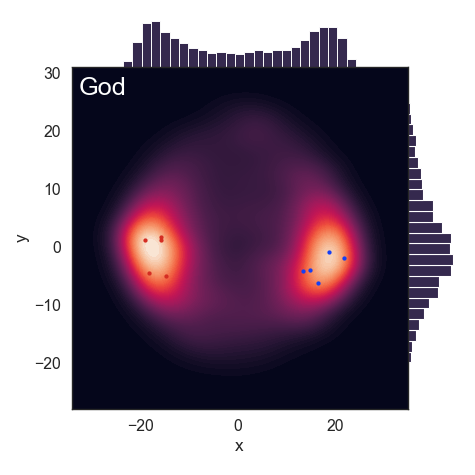

In [92]:
keywords=['God']
g = draw_keyword_kde(keywords)
ax = g.ax_joint

lx = dat.iloc[god_left_indices]['x']
ly = dat.iloc[god_left_indices]['y']

rx = dat.iloc[god_right_indices]['x']
ry = dat.iloc[god_right_indices]['y']

sns.scatterplot(x=lx, y=ly, marker='o', s=15, color='#D52D23', linewidth=0,  alpha=1, ax=ax)
sns.scatterplot(x=rx, y=ry, marker='o', s=15, color='#143FF5', linewidth=0,  alpha=1, ax=ax)

plt.savefig('../fig/BeliefSpaceExamples/belief_kdeplot_keyword_(%s)_withmarker.png'%(keywords[0]), 
            dpi=300, transparent=False, bbox_inches='tight')

### keyword: Abortion

In [93]:
dat = get_popular_beliefs(['Abortion'], n=40)

N samples: 908
0 I disagree with the following: Should abortion be legal? (N:51) (-16.8, -0.9)
1 I agree with the following: Should abortion be legal? (N:41) (15.2, -4.5)
2 I disagree with the following: Late term abortion is morally correct in every situation (N:24) (-14.2, 0.6)
3 I agree with the following: Late term abortion is morally correct in every situation (N:15) (16.0, -3.1)
4 I agree with the following: Should abortion be legal (N:14) (15.4, -4.7)
5 I agree with the following: Should abortion be illegal? (N:13) (0.4, 1.4)
6 I disagree with the following: Should abortion be illegal? (N:12) (4.1, -7.0)
7 I agree with the following: Should Abortion be legal? (N:10) (15.2, -4.5)
8 I disagree with the following: Should Abortion be Legal? (N:10) (-16.8, -0.9)
9 I disagree with the following: Should abortion be legal (N:10) (-17.3, 0.0)
10 I agree with the following: Is abortion murder? (N:10) (-17.0, -3.7)
11 I agree with the following: Should Abortion be Legal? (N:10) (15.2, -4.5

In [98]:
abo_left_indices = [0, 2, 10, 16, 29]
abo_right_indices = [1, 3, 21, 26, 35]

for i in range(5):
    print("(%.1f, %.1f), %s"%(dat.iloc[abo_left_indices].iloc[i]['x'], dat.iloc[abo_left_indices].iloc[i]['y'], dat.iloc[abo_left_indices].iloc[i]['belief']))
print()
for i in range(5):    
    print("(%.1f, %.1f), %s"%(dat.iloc[abo_right_indices].iloc[i]['x'], dat.iloc[abo_right_indices].iloc[i]['y'], dat.iloc[abo_right_indices].iloc[i]['belief']))

(-16.8, -0.9), I disagree with the following: Should abortion be legal?
(-14.2, 0.6), I disagree with the following: Late term abortion is morally correct in every situation
(-17.0, -3.7), I agree with the following: Is abortion murder?
(-18.4, -3.8), I agree with the following: If the fetus is a human person, then abortion is generally immoral
(-13.5, 0.6), I disagree with the following: Should abortion be legalized?

(15.2, -4.5), I agree with the following: Should abortion be legal?
(16.0, -3.1), I agree with the following: Late term abortion is morally correct in every situation
(16.3, 0.8), I disagree with the following: Social Abortions ought to be banned in the US.
(10.6, -2.6), I disagree with the following: There is no difference between abortion and and gun murder.
(15.5, -4.8), I agree with the following: should abortion be allowed in the US?


N samples: 908


<IPython.core.display.Javascript object>


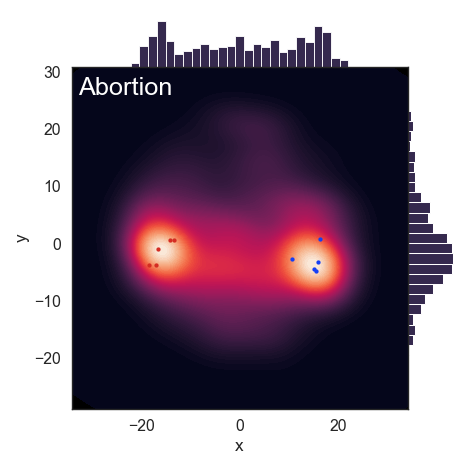

In [95]:
keywords=['Abortion']
g = draw_keyword_kde(keywords)
ax = g.ax_joint

lx = dat.iloc[abo_left_indices]['x']
ly = dat.iloc[abo_left_indices]['y']

rx = dat.iloc[abo_right_indices]['x']
ry = dat.iloc[abo_right_indices]['y']

sns.scatterplot(x=lx, y=ly, marker='o', s=15, color='#D52D23', linewidth=0,  alpha=1, ax=ax)
sns.scatterplot(x=rx, y=ry, marker='o', s=15, color='#143FF5', linewidth=0,  alpha=1, ax=ax)

plt.savefig('../fig/BeliefSpaceExamples/belief_kdeplot_keyword_(%s)_withmarker.png'%(keywords[0]), 
            dpi=300, transparent=False, bbox_inches='tight')

## 3D visualization

In [202]:
def get_related_beliefs_3d(keywords, pc_x=0, pc_y=1, pc_z=2): 
    #pc_x, pc_y = pc index
    related_beliefs = []
    related_beliefs_vectors = []
    related_beliefs_pcvec = []

    for e in belief_keys:
        for k in keywords:
            if k.lower() in e.lower(): #convert to lower case 
                related_beliefs.append(e)
                b_idx = belief2idx[e]
                related_beliefs_vectors.append(belief_vectors[b_idx])
                related_beliefs_pcvec.append(pca_vectors[b_idx])

    related_beliefs_vectors = np.array(related_beliefs_vectors)            
    related_beliefs_pcvec   = np.array(related_beliefs_pcvec)

    x = related_beliefs_pcvec[:,pc_x]
    y = related_beliefs_pcvec[:,pc_y]
    z = related_beliefs_pcvec[:,pc_z]
    
    dat = pd.DataFrame({'x':x, 'y':y, 'z':z, 'belief':related_beliefs})
    
    print("N samples:", len(x))
    return x, y, z, dat

In [203]:
%matplotlib notebook

N samples: 5324


<IPython.core.display.Javascript object>


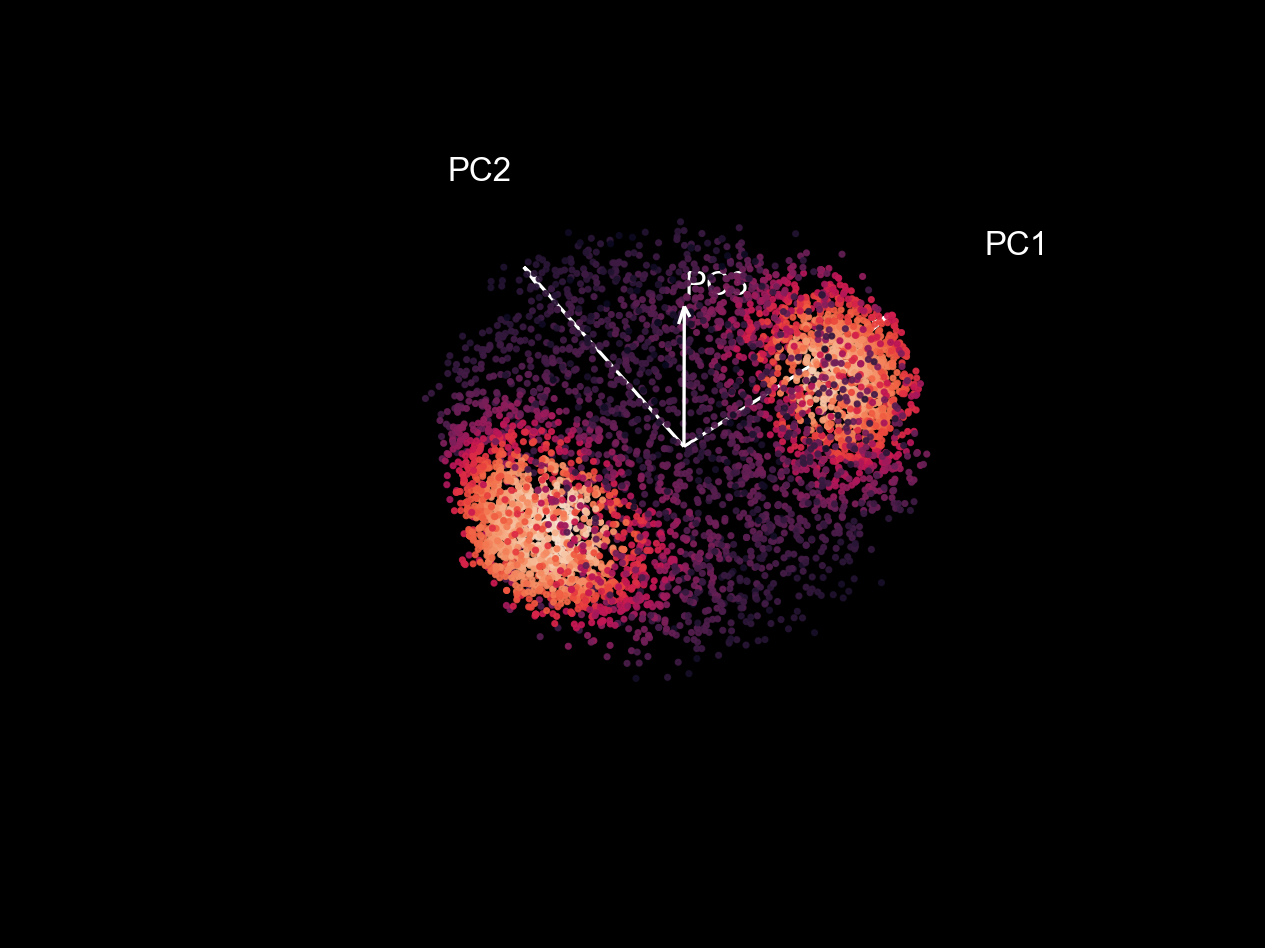

In [386]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from scipy.spatial import cKDTree
from matplotlib import cm


keywords=['God']
x, y, z, dat = get_related_beliefs_3d(keywords, pc_x=0, pc_y=1, pc_z=2)
xs, ys, zs = dat['x'], dat['y'], dat['z']


# Create a KDTree for efficient neighbor search
tree = cKDTree(np.vstack((xs, ys, zs)).T)

# Determine the number of neighbors within a specified radius for each point
radius = 10
neighbors = [len(tree.query_ball_point(point, r=radius)) for point in np.vstack((xs, ys, zs)).T]

# Normalize neighbor counts for color mapping
max_neighbors = max(neighbors)
colors = [sns.cm.rocket(count / max_neighbors) for count in neighbors]#rocket, mako

#fig = plt.figure(figsize=(10,7), facecolor='black')
fig = plt.figure(figsize=(8,6), facecolor='black')
ax = fig.add_axes([0.05, 0.05, 0.95, 0.95], projection='3d', facecolor='black')

scatter = ax.scatter(xs, ys, zs, c=colors, s=5, alpha=0.9)#s=10

# Make panes (the xy, yz and zx planes) invisible
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

# Parameters: x, y, z start points, u, v, w direction vectors
ax.quiver(0, 0, 0, 1, 0, 0, length=25, color='w', arrow_length_ratio=0.1)
ax.quiver(0, 0, 0, 0, 1, 0, length=25, color='w', arrow_length_ratio=0.1)
ax.quiver(0, 0, 0, 0, 0, 1, length=25, color='w', arrow_length_ratio=0.1)

max_range = (max(xs), max(ys), max(zs))
ax.text(max_range[0]*1.5, 0, 0, "PC1", color='w', fontsize=15)
ax.text(0, max_range[1]*1.5, 0, "PC2", color='w', fontsize=15)
ax.text(0, 0, max_range[2]*1.5, "PC3", color='w', fontsize=15)


# Setting the background color
ax.set_facecolor('black')

# Hide grid lines
ax.grid(False)

# Hide axes ticks
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])


ax.xaxis.pane.set_edgecolor((0.0, 0.0, 0.0, 0.0))
ax.yaxis.pane.set_edgecolor((0.0, 0.0, 0.0, 0.0))
ax.zaxis.pane.set_edgecolor((0.0, 0.0, 0.0, 0.0))

ax.xaxis.line.set_linewidth(0)
ax.yaxis.line.set_linewidth(0)
ax.zaxis.line.set_linewidth(0)

ax.w_xaxis.line.set_linewidth(0)
ax.w_yaxis.line.set_linewidth(0)
ax.w_zaxis.line.set_linewidth(0)


# Number of frames for the animation
num_frames = 180

# Animation function
def update(frame):
    # Calculating the new angles
    elev = 10 + frame/3
    #elev = 70
    azim =  frame + 90
    ax.view_init(elev=elev, azim=azim)
    return fig,


# Create animation
ani = FuncAnimation(fig, update, frames=num_frames, blit=False)
#ax.text(20, 20, 0, "%s"%(keywords[0]), fontsize=15, color='y')
#ax.text(20, 20, 0, "사람들의 생각", fontsize=15, color='y')
# Save the animation
#ani.save('../fig/3d_rotation_density_colors_%s.gif'%keywords[0], writer='imagemagick', fps=30)
ani.save('../fig/3d_rotation_density_colors_%s.mov'%(keywords[0]), 
         writer='ffmpeg', fps=30, extra_args=['-vcodec', 'libx264'], dpi=300)

plt.show()

## + UMAP of belief vectors

In [10]:
import umap

In [366]:
reducer = umap.UMAP(n_neighbors=20, n_components=2, random_state=42, spread=3 )
data_2d = reducer.fit_transform(belief_vectors)

/Users/byunghwee/miniforge3/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [726]:
dat_umap = pd.DataFrame({'x':data_2d[:,0], 'y':data_2d[:,1]})
dat_umap.head()

x         y
0  1.980758 -0.275920
1 -0.131169  6.994116
2  6.790987 -1.306797
3  9.937509  6.663512
4  2.135254 -3.969930

<AxesSubplot:xlabel='x', ylabel='y'>

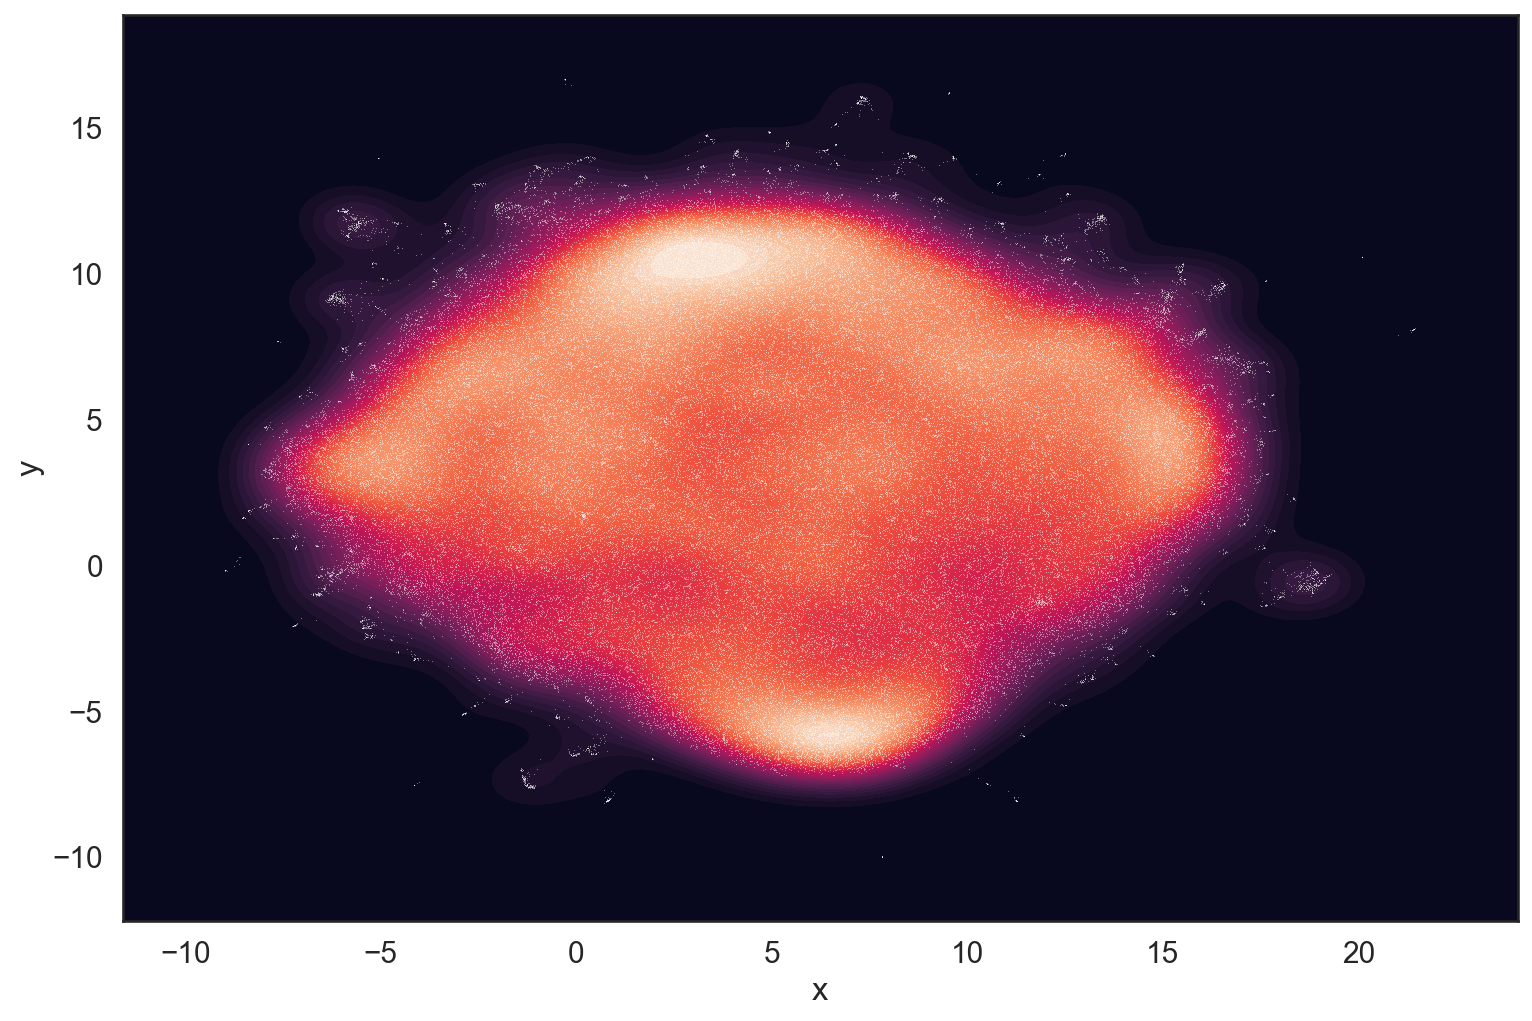

In [732]:
fig,ax = plt.subplots(figsize=(12,8))
sns.kdeplot(x=dat_umap['x'], y=dat_umap['y'], cmap='rocket', fill=True, thresh=0, levels=100, ax=ax)
sns.scatterplot(x=dat_umap['x'], y=dat_umap['y'], fc="w", s=0.1,  ax=ax)


<Figure size 1800x1200 with 0 Axes>

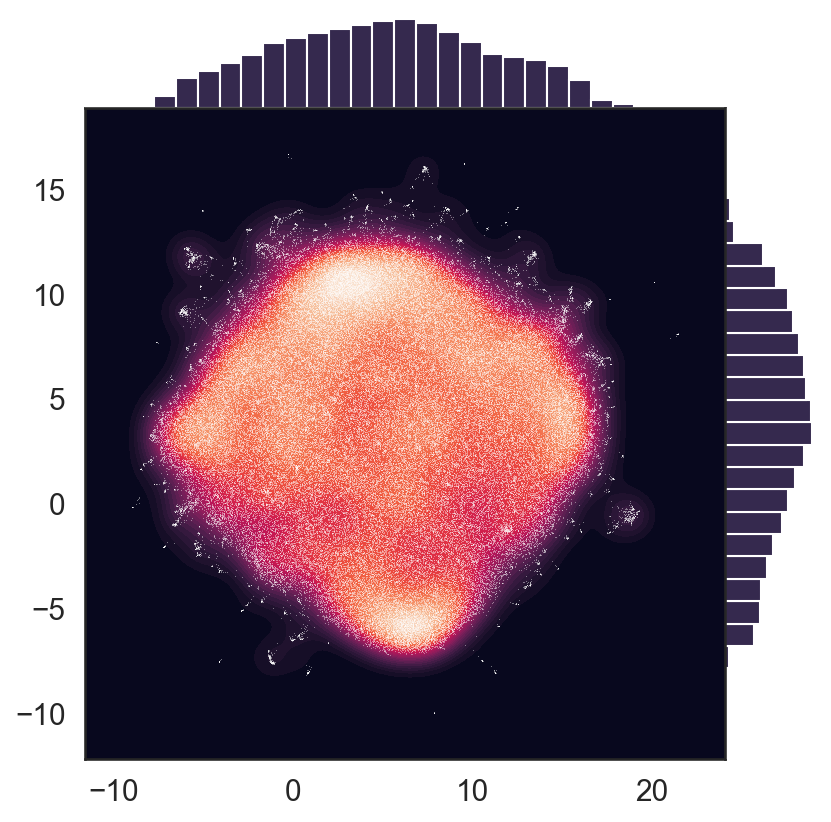

In [729]:
rc = {'figure.figsize':(12,8)}
sns.set_theme(style="white", font_scale=1.3, rc=rc)


plt.figure()
g = sns.JointGrid(data=dat_umap, x="x", y="y", space=0.0, ratio=7)

g.ax_joint.set_facecolor("black")

g.plot_joint(sns.kdeplot,
             fill=True, 
             thresh=0,
             cmap="rocket",
             levels=100)

sns.scatterplot(x=dat_umap['x'], y=dat_umap['y'], fc="w", s=0.1,  ax=g.ax_joint)

g.plot_marginals(sns.histplot, color="#35294E", alpha=1, bins=25)

g.set_axis_labels(xlabel=None, )

plt.savefig('../fig/BeliefSpaceExamples(UMAP)/belief_space_visualization_smooth.png', transparent=True, bbox_inches='tight')
plt.show()

In [369]:
def get_related_beliefs_umap(keywords): 
    related_beliefs = set()
    related_beliefs_umapvec = []

    for e in belief_keys:
        for k in keywords:
            if k.lower() in e.lower(): #convert to lower case 
                related_beliefs.add(e)
    
    related_beliefs = list(related_beliefs)
    
    for b in related_beliefs:
        b_idx = belief2idx[b]
        related_beliefs_umapvec.append(data_2d[b_idx])

    related_beliefs_umapvec = np.array(related_beliefs_umapvec)

    x = related_beliefs_umapvec[:,0]
    y = related_beliefs_umapvec[:,1]
    
    dat = pd.DataFrame({'x':x, 'y':y, 'belief':related_beliefs})
    
    print("N samples:", len(x))
    return x, y, dat

In [718]:
def draw_keyword_kde_umap(keywords, palette='rocket', labeloff=0):
    
    color = palette
            
    x, y, dat = get_related_beliefs_umap(keywords)    
    sns.set_theme(style="white", font_scale=1.3)
    g = sns.JointGrid(data=dat, x="x", y="y", space=0.0, ratio=7)
    
    ax = g.ax_joint
    #ax.fill_betweenx([30, 30], -30, 30, color='black')
    sns.kdeplot(data=dat, x='x', y='y', fill=True, thresh=0.0, cmap=color, levels=100, ax=ax)
    ax.set_facecolor("black")
    g.plot_marginals(sns.histplot, color="#DF6E50", alpha=1, linewidth=0.5, edgecolor='k', bins=25)
    g.set_axis_labels(xlabel=None)
        
    
    for line in plt.gca().get_lines():
        line.set_color('k')
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")
    

    
    if labeloff==0:
        if len(keywords) > 2:
            ax.text(.02, .97,  s=", ".join(keywords), ha='left', va='top', color='w', fontsize=22, transform=ax.transAxes)
        else:
            ax.text(.02, .97,  s=", ".join(keywords), ha='left', va='top', color='w', fontsize=23, transform=ax.transAxes)
    
    return g

In [568]:
def draw_scatter_umap(keywords, ax, color='r', alpha=1):
    
    x, y, dat = get_related_beliefs_umap(keywords)
    sns.scatterplot(x=dat['x'], y=dat['y'], marker='o', color=color, s=5,  alpha=alpha, linewidth=0.0,
                    ax=ax, label='%s'%", ".join(keywords))
    #ax.set_axis_off()

N samples: 5324
N samples: 908
N samples: 1618
N samples: 242
N samples: 380
N samples: 1392
N samples: 710
N samples: 324
N samples: 342
N samples: 158


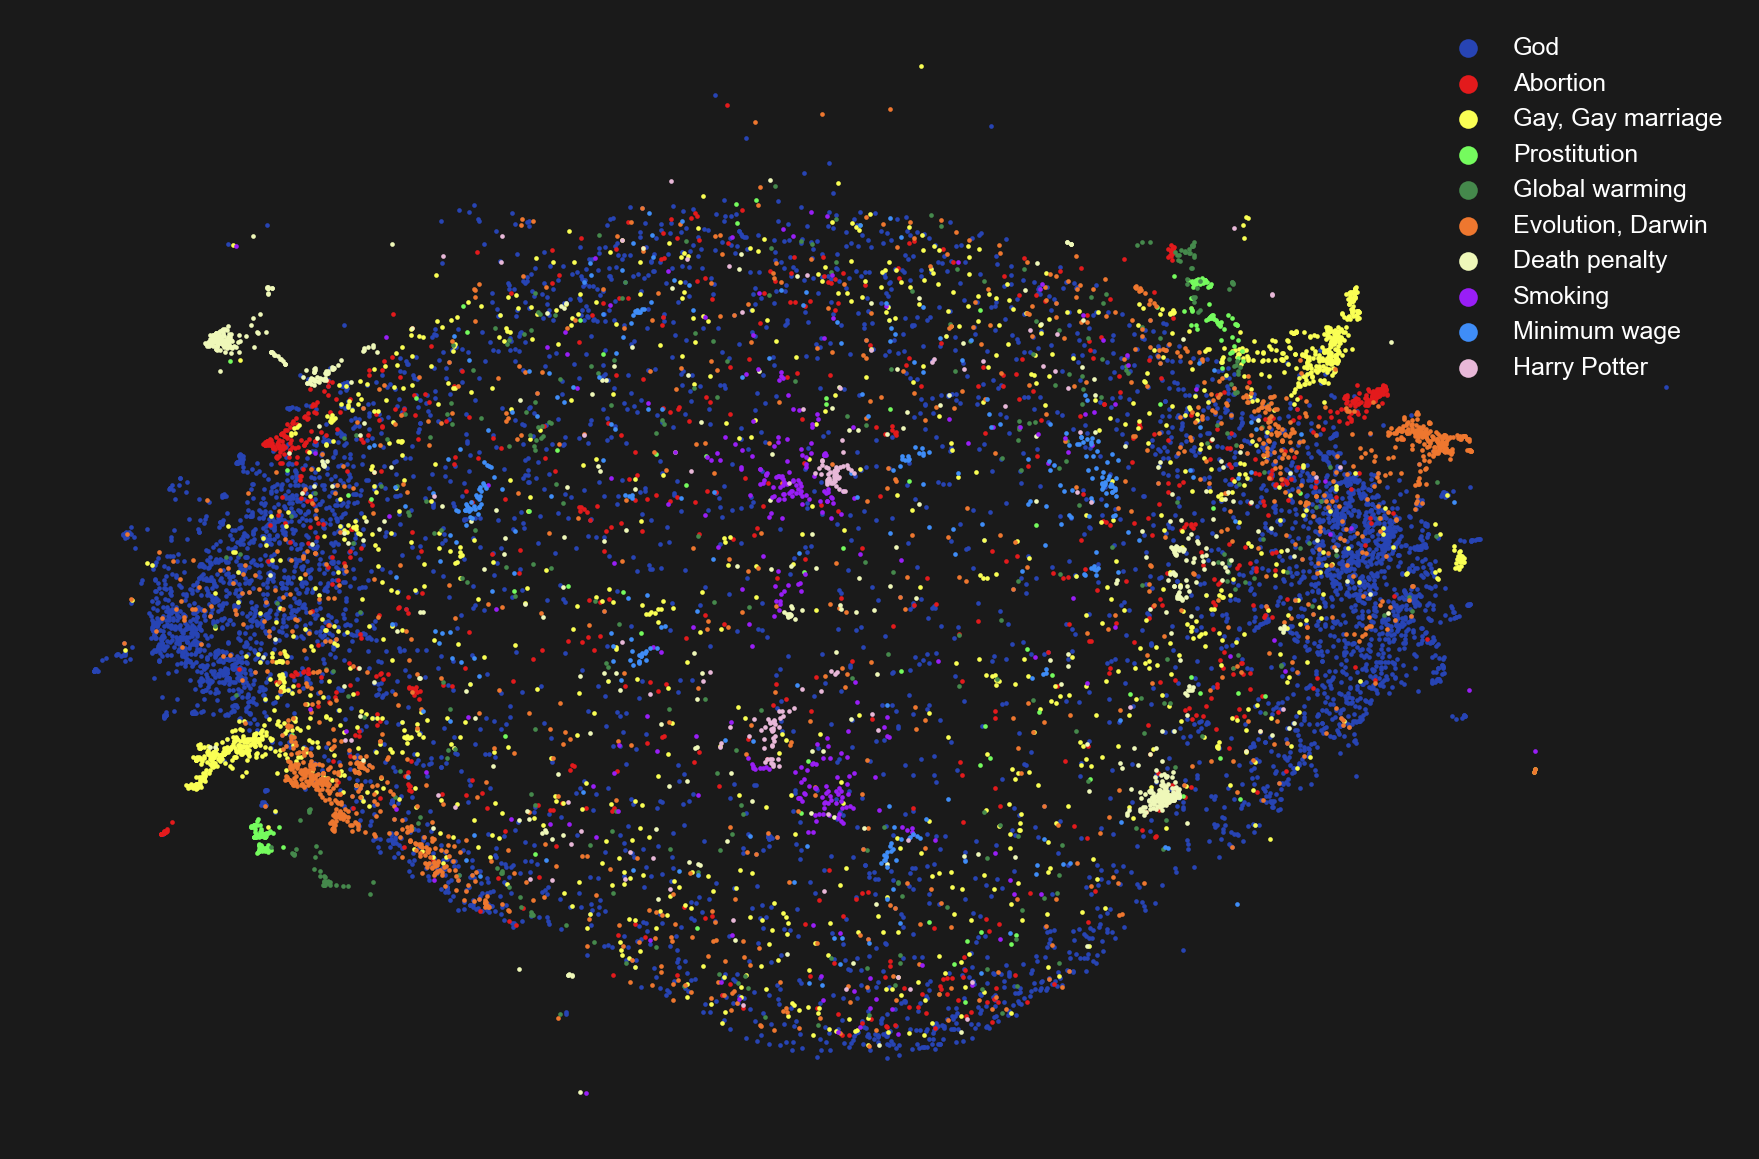

In [737]:
keywords_list = [['Abortion'], 
                 ['Gay','Gay marriage'], 
                 ['Prostitution'], 
                 ['Global warming'], 
                 ['Evolution','Darwin'], 
                 ['Death penalty'],
                 ['Smoking'], 
                 ['Minimum wage'],
                 ['Harry Potter']]

colors = [
"#e31a1c", 
"#FAFF54",
"#75FB5E",
"#45894C",
"#EE772F",
"#EFF8B9",
"#991EF6",
"#3F8DF7",
"#E8B8D8",
]

sns.set_theme(style="white", font_scale=1.3)

fig, ax = plt.subplots(facecolor='k', figsize=(12,8))
draw_scatter_umap(['God'], ax, color='#2744B4', alpha=1)#323690

for idx, keyword in enumerate(keywords_list):
    #print(keyword)
    color = plt.cm.gist_rainbow(idx / len(keywords_list))
    draw_scatter_umap(keyword, ax, color=colors[idx])
    
    
ax.set_facecolor('k')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("")
ax.set_ylabel("")

for pos in ['right', 'top', 'bottom', 'left']: 
    ax.spines[pos].set_visible(False)

ax.legend(markerscale=4, loc='best', fontsize=12, frameon=False, labelcolor='w')
plt.tight_layout()
plt.savefig('../fig/BeliefSpaceExamples(UMAP)/keywords_umap.png', dpi=300)
plt.show()


N samples: 5324
N samples: 908
N samples: 1618
N samples: 242
N samples: 380
N samples: 1392
N samples: 710
N samples: 342
N samples: 138
N samples: 158
N samples: 140
N samples: 324


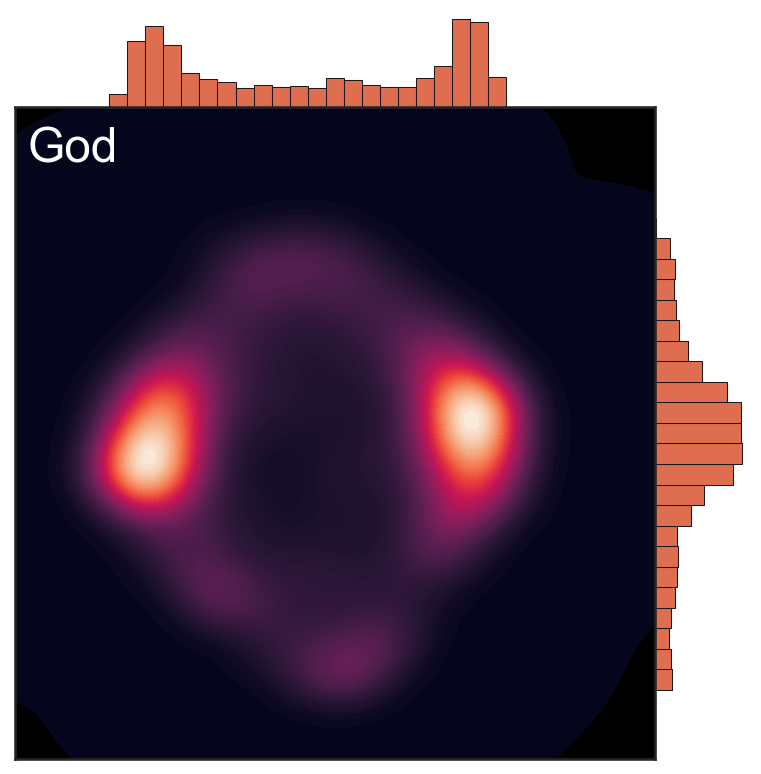

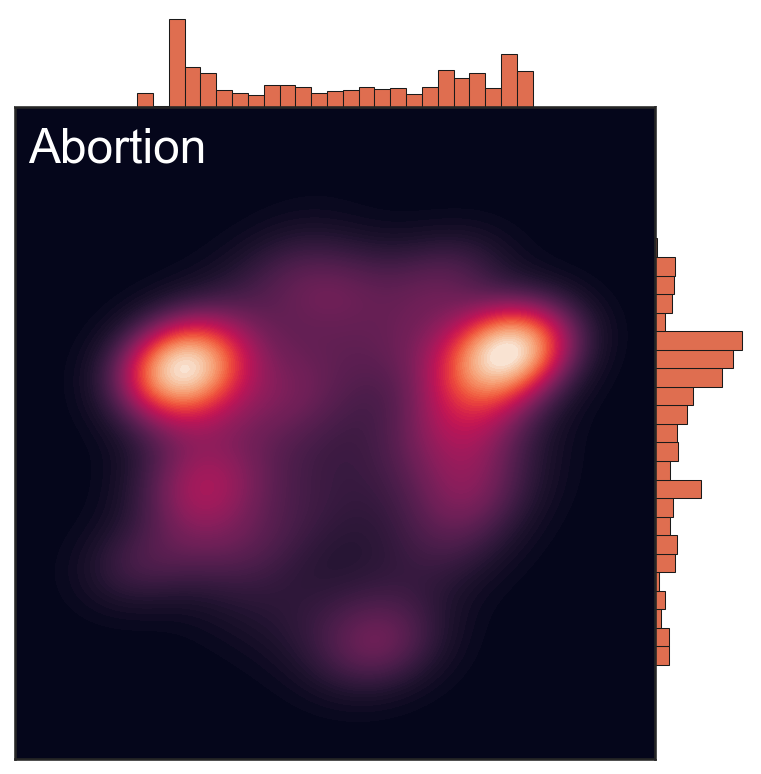

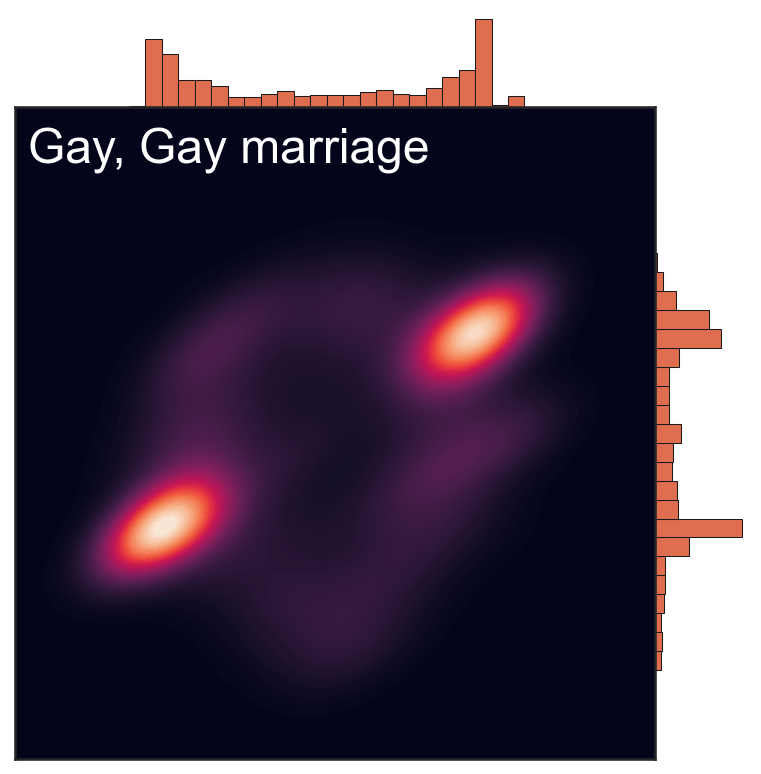

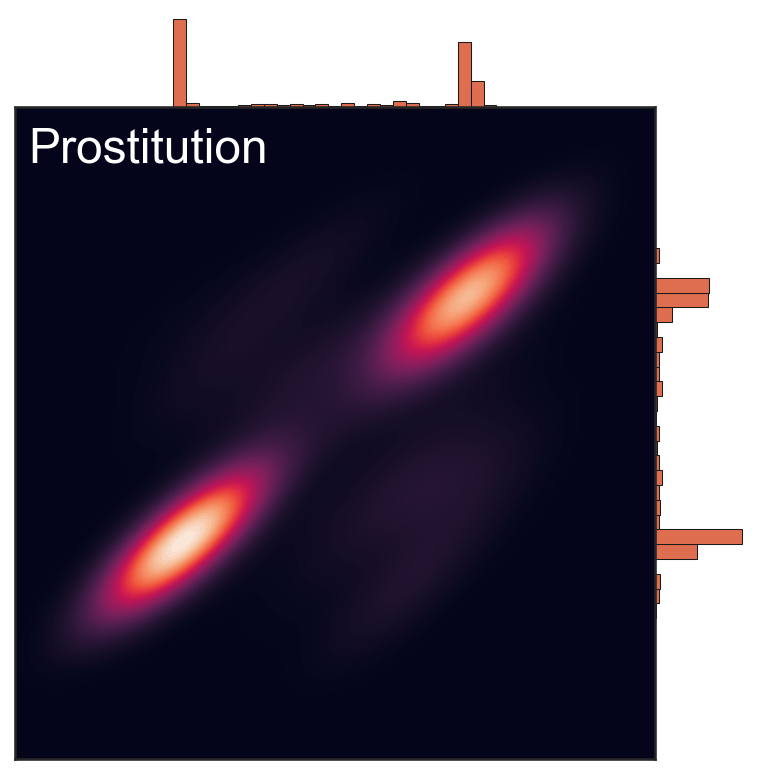

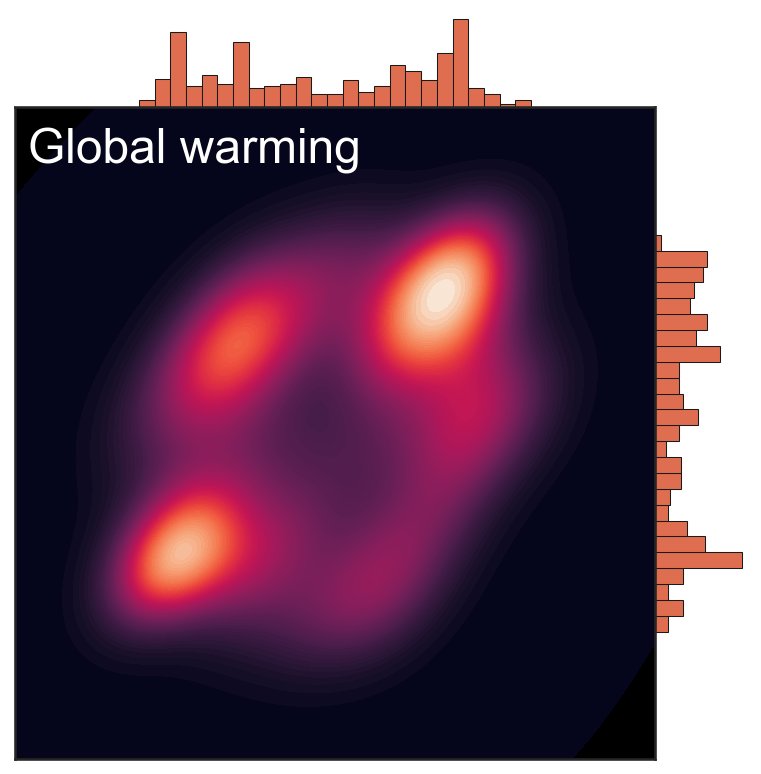

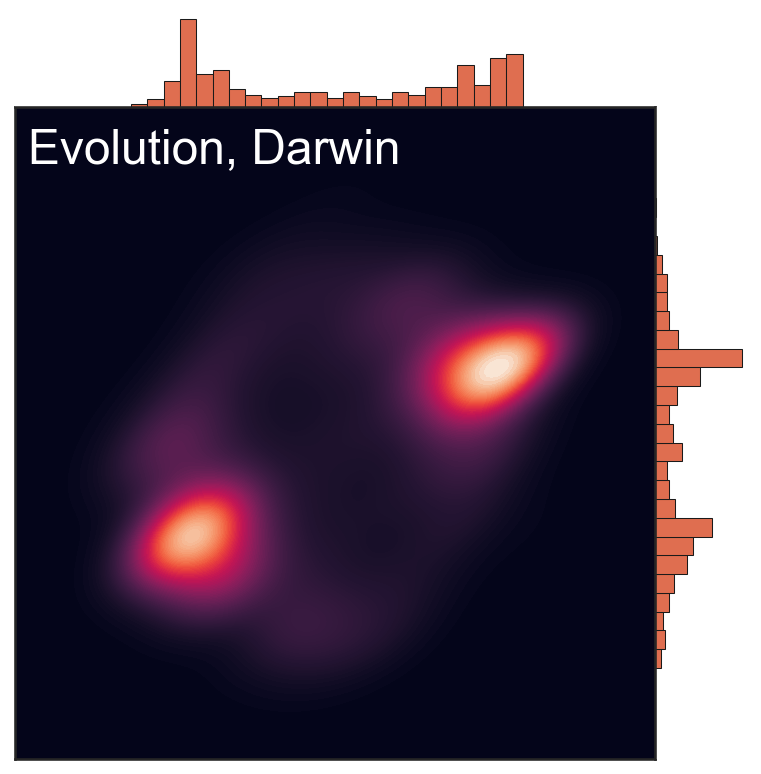

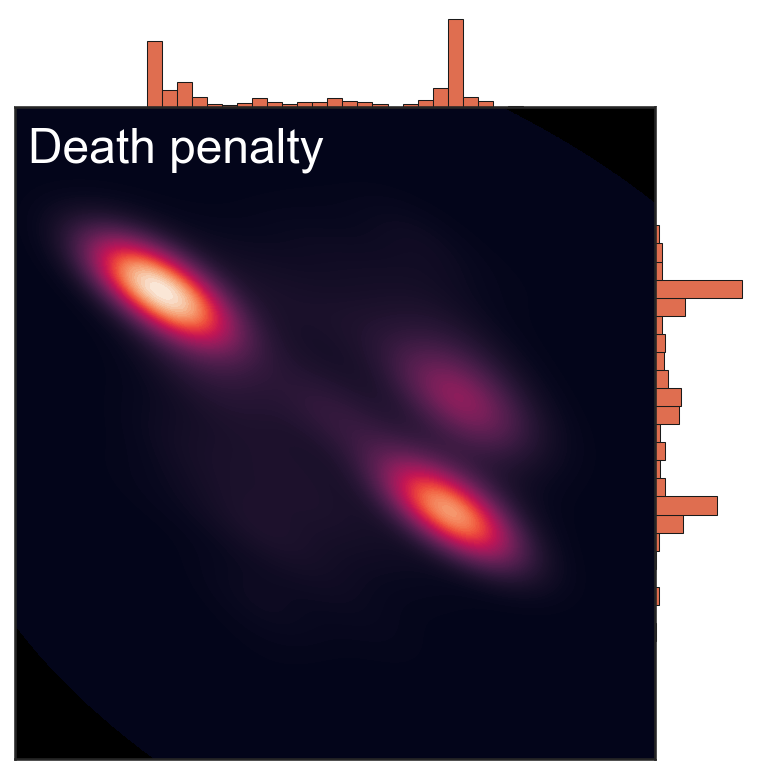

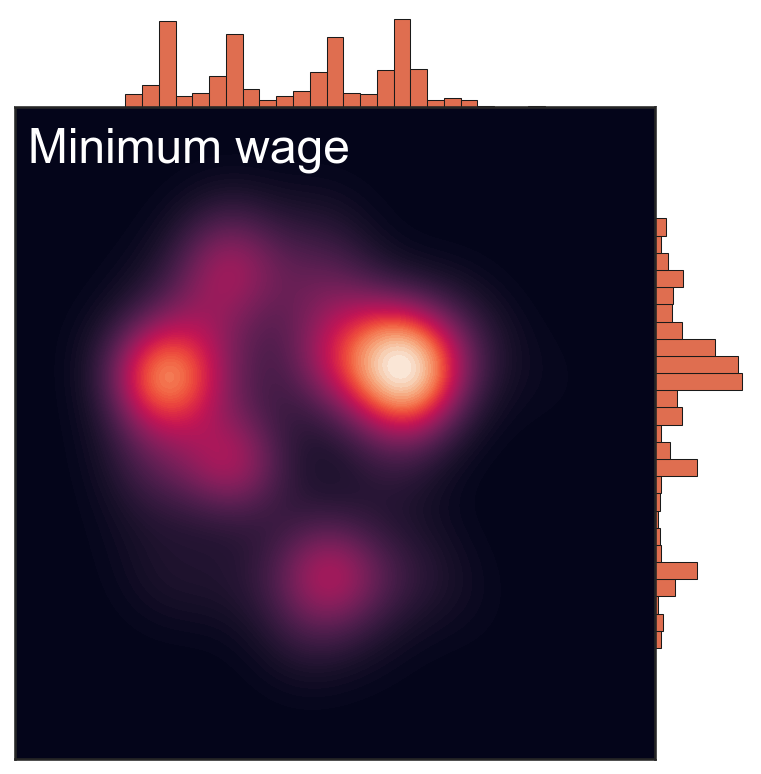

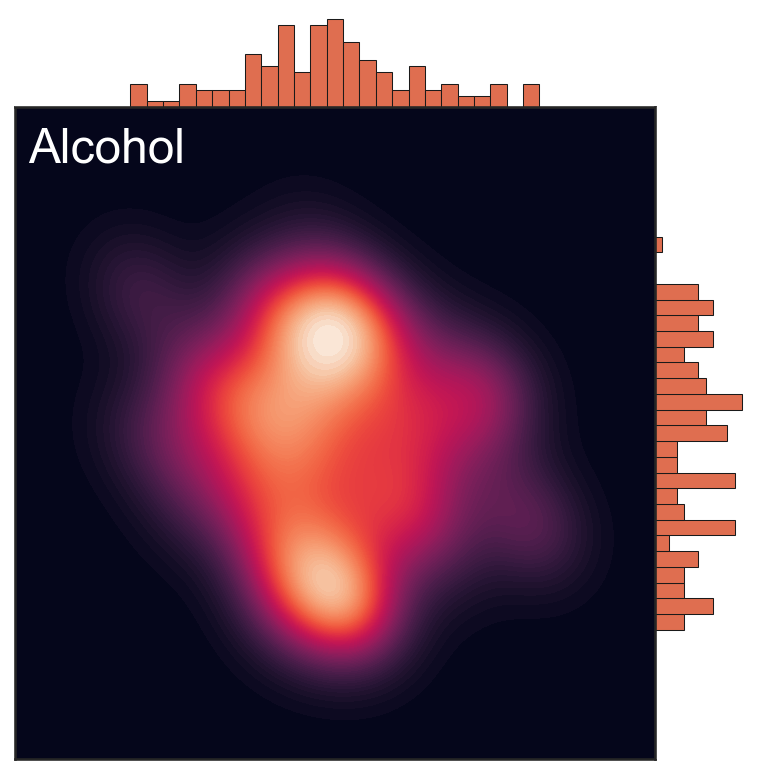

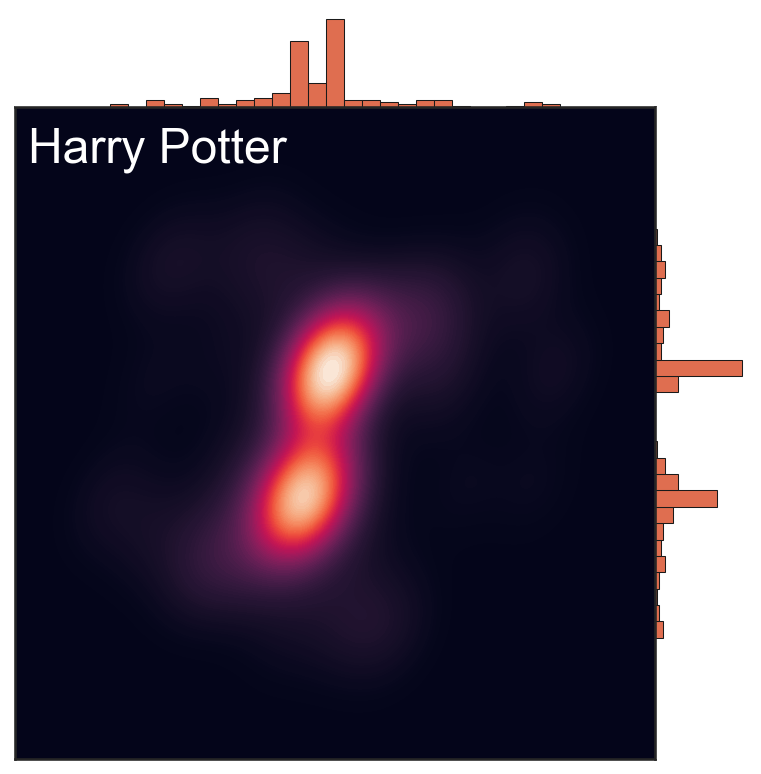

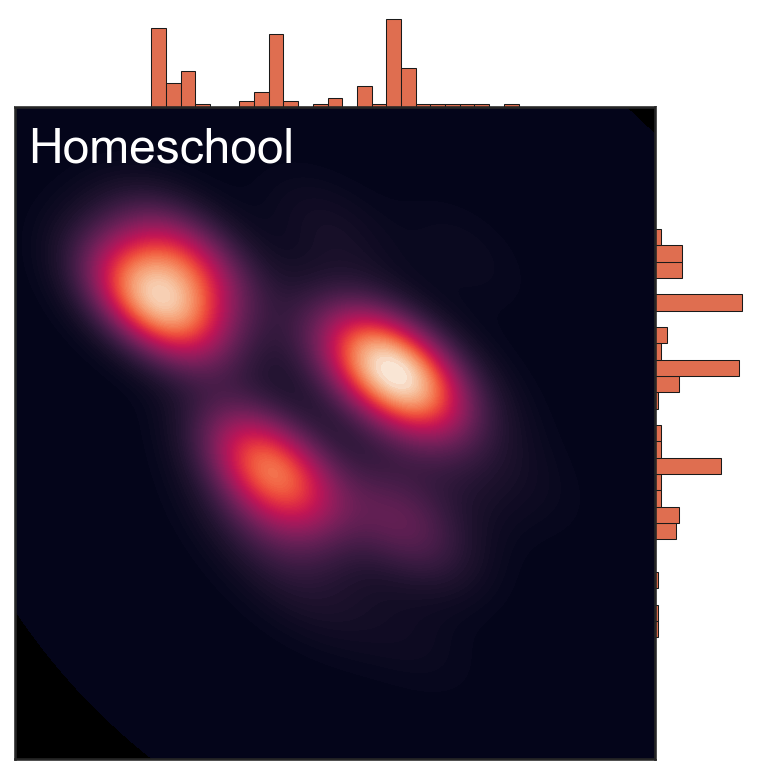

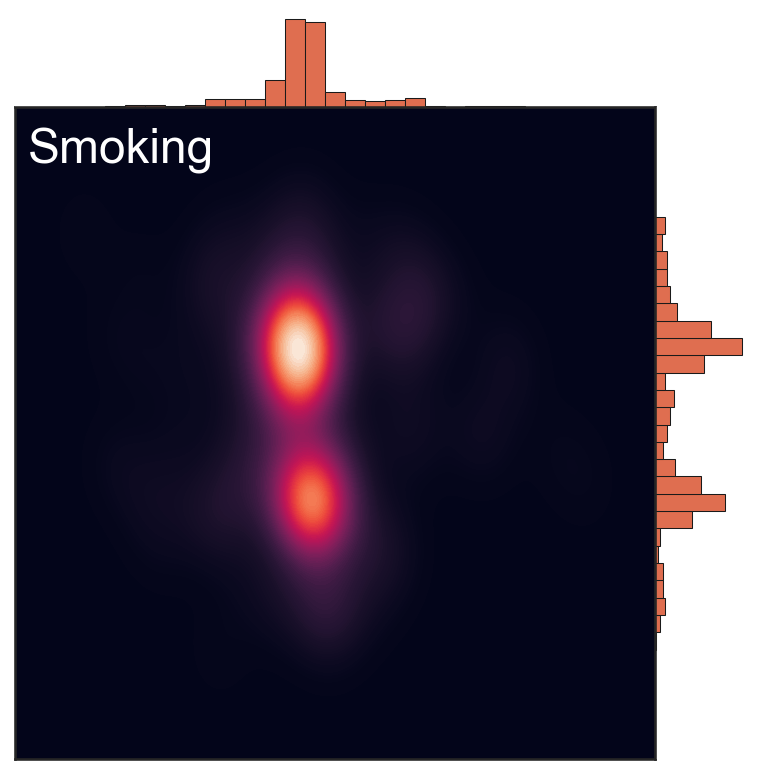

In [736]:
keywords_list = [['God'], ['Abortion'], ['Gay','Gay marriage'], ['Prostitution'], 
                 ['Global warming'], ['Evolution','Darwin'], ['Death penalty'], 
                 ['Minimum wage'], ['Alcohol'], ['Harry Potter'], ['Homeschool'], ['Smoking']]

for idx, keyword in enumerate(keywords_list):

    draw_keyword_kde_umap(keyword)
    
    plt.savefig('../fig/BeliefSpaceExamples(UMAP)/belief_kdeplot_keyword_(%s).png'%(keyword[0]), 
            dpi=300, transparent=0, bbox_inches='tight')
    

## Representing example beliefs in the scatter plot

In [745]:
belief2cnt = df_train['belief_statement'].value_counts().to_dict()

In [746]:
def get_popular_beliefs_umap(keywords, n=20, pc_x=0, pc_y=1):
    #keywords = ['God']
    x, y, dat = get_related_beliefs_umap(keywords)
    dat['count'] = dat['belief'].map(belief2cnt)
    dat = dat.sort_values(by='count', ascending=0)
    
    for i in range(n):
        print(i, dat['belief'].iloc[i], "(N:%d)"%(dat['count'].iloc[i]), "(%.1f, %.1f)"%(dat['x'].iloc[i], dat['y'].iloc[i]) )
        
    return dat

In [769]:
get_popular_beliefs_umap(['Abortion'], n=40)

N samples: 908
0 I disagree with the following: Should abortion be legal? (N:51) (-5.2, 6.9)
1 I agree with the following: Should abortion be legal? (N:41) (16.0, 8.0)
2 I disagree with the following: Late term abortion is morally correct in every situation (N:24) (-2.3, 3.4)
3 I agree with the following: Late term abortion is morally correct in every situation (N:15) (14.5, 7.9)
4 I agree with the following: Should abortion be legal (N:14) (15.9, 7.9)
5 I agree with the following: Should abortion be illegal? (N:13) (-7.3, -2.1)
6 I disagree with the following: Should abortion be illegal? (N:12) (12.0, 11.3)
7 I disagree with the following: Should Abortion be Legal? (N:10) (-5.2, 6.9)
8 I agree with the following: Is abortion murder? (N:10) (-4.0, 3.6)
9 I agree with the following: Should Abortion be Legal? (N:10) (16.0, 8.0)
10 I agree with the following: sould abortion be legal (N:10) (15.8, 7.8)
11 I disagree with the following: Should abortion be legal (N:10) (-5.2, 6.8)
12 I agree

x          y                                             belief  \
431  -5.180581   6.893155  I disagree with the following: Should abortion...   
439  16.004208   8.020860  I agree with the following: Should abortion be...   
590  -2.278466   3.424687  I disagree with the following: Late term abort...   
434  14.457460   7.872959  I agree with the following: Late term abortion...   
130  15.907440   7.922046  I agree with the following: Should abortion be...   
..         ...        ...                                                ...   
499  15.470271   7.789786        I agree with the following: Is abortion ok?   
500  -4.271861   4.699317  I agree with the following: The USFG Should Ba...   
157   1.478586  10.128822  I disagree with the following: Experiments on ...   
502  -2.607488  -0.762488  I disagree with the following: Is abortion eth...   
0     8.613422  -5.847658  I agree with the following: infants born in bo...   

     count  
431     51  
439     41  
590     24  
434     15  
130     14  
..     ...  
499      1  
500      1  
157      1  
502      1  
0        1  

[908 rows x 4 columns]

In [772]:
x_examples_god = [-6.47, -5.8, 15.51, 15.6]
y_examples_god = [1.19, 6.4, 6.14, 0.6,]
x_examples_abortion = [-5.2, -4.4, 14.5, 16.0]
y_examples_abortion = [6.9, 7.7, 7.9, 8.0]

N samples: 5324
N samples: 908
N samples: 1618
N samples: 242
N samples: 380
N samples: 1392
N samples: 710
N samples: 324
N samples: 342
N samples: 158


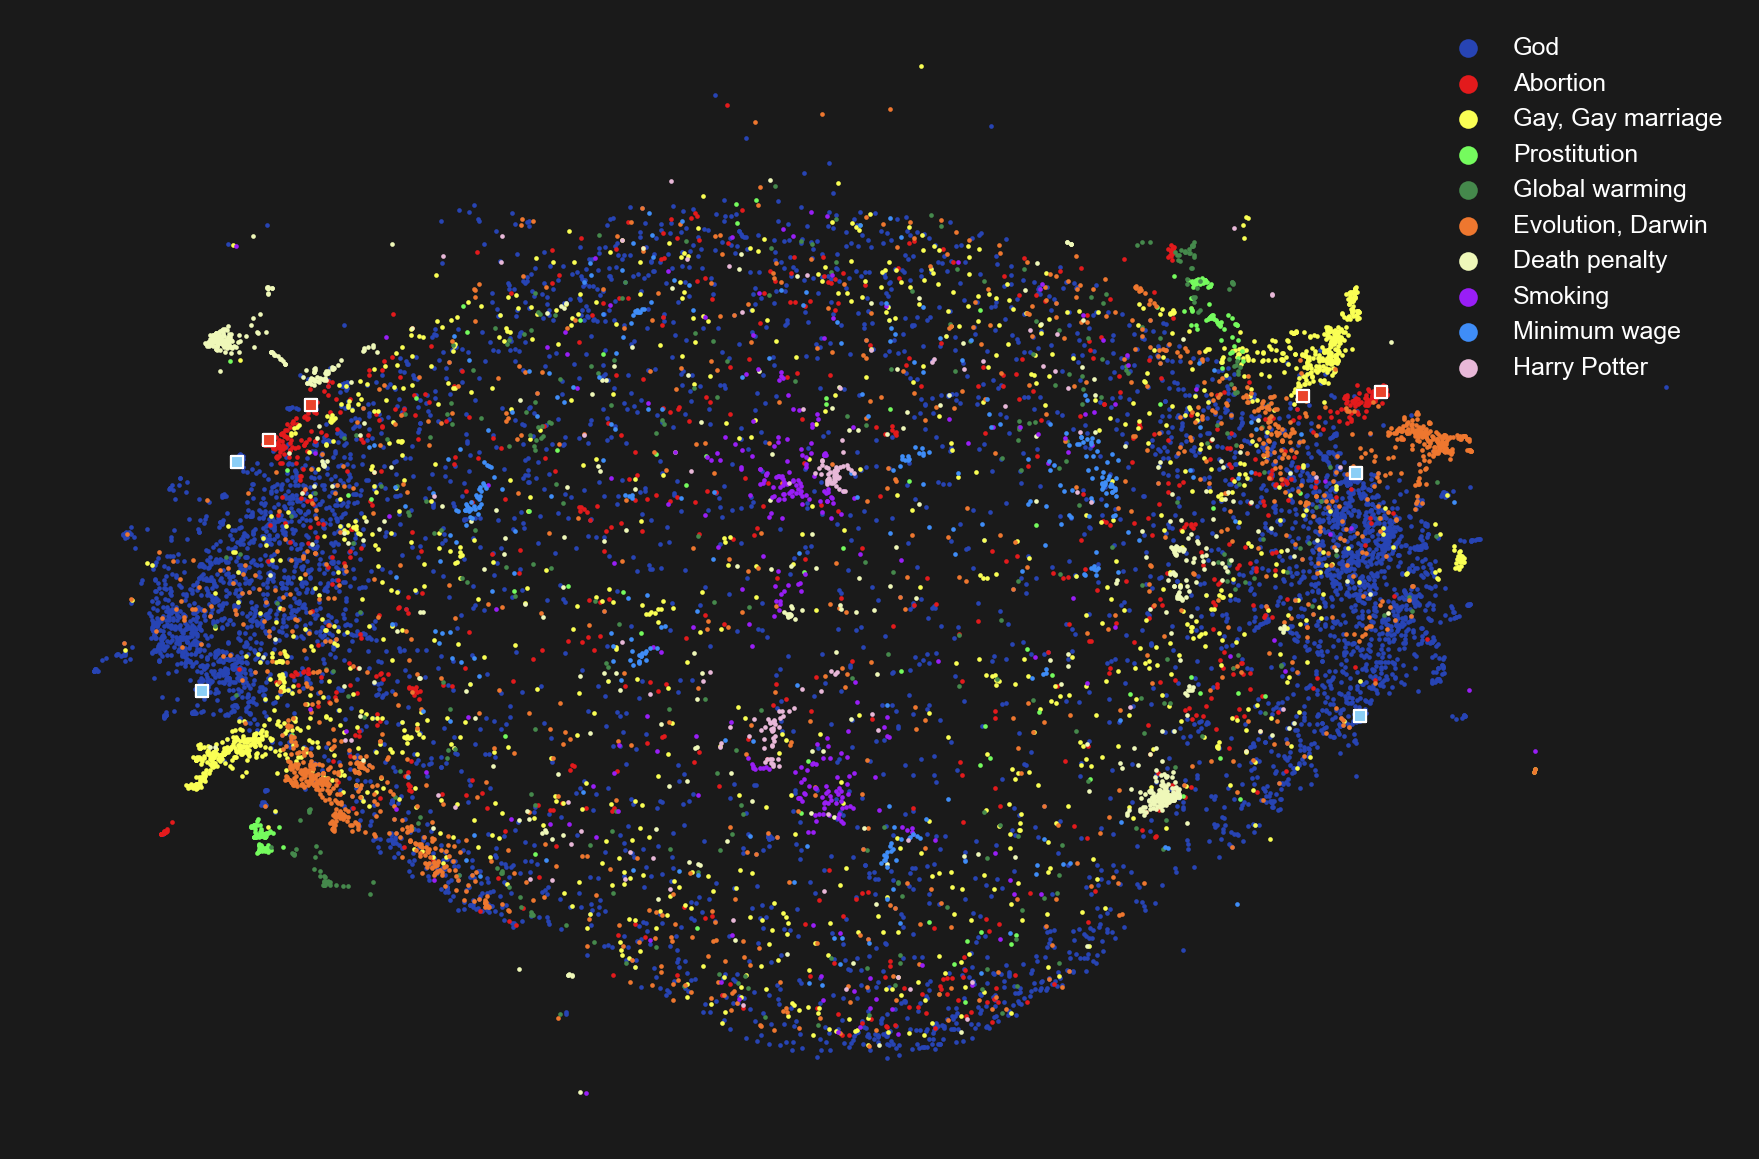

In [777]:
keywords_list = [['God'], 
                 ['Abortion'], 
                 ['Gay','Gay marriage'], 
                 ['Prostitution'], 
                 ['Global warming'], 
                 ['Evolution','Darwin'], 
                 ['Death penalty'],
                 ['Smoking'], 
                 ['Minimum wage'],
                 ['Harry Potter']]

colors = [
'#2744B4',
"#e31a1c", 
"#FAFF54",
"#75FB5E",
"#45894C",
"#EE772F",
"#EFF8B9",
"#991EF6",
"#3F8DF7",
"#E8B8D8",
]

sns.set_theme(style="white", font_scale=1.3)
fig, ax = plt.subplots(facecolor='k', figsize=(12,8))

#main scatter
for idx, keyword in enumerate(keywords_list):
    color = plt.cm.gist_rainbow(idx / len(keywords_list))
    draw_scatter_umap(keyword, ax, color=colors[idx])

#examples
for i in range(len(x_examples_god)):
    ax.scatter(x_examples_god, y_examples_god, s=30, color='#8ACEF6', marker='s', edgecolor='w', alpha=1, linewidth=1.)

for i in range(len(x_examples_abortion)):
    ax.scatter(x_examples_abortion, y_examples_abortion, s=30, color='#EA442B', marker='s', edgecolor='w', alpha=1, linewidth=1.)
    
    
    
ax.set_facecolor('k')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("")
ax.set_ylabel("")

for pos in ['right', 'top', 'bottom', 'left']: 
    ax.spines[pos].set_visible(False)

ax.legend(markerscale=4, loc='best', fontsize=12, frameon=False, labelcolor='w')
plt.tight_layout()
plt.savefig('../fig/BeliefSpaceExamples(UMAP)/keywords_umap_with_examplemarkers.png', dpi=300)
plt.show()
